In [3]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata, chi2_contingency
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from model_grouping import *
import seaborn as sns

In [4]:
logits_dir = "../../logits_results"
race_categories = [
    "asian",
    "black",
    "white",
    "hispanic",
    "indigenous",
    "pacific islander"
]

gender_categories = [
    "male",
    "female",
    "non-binary",
]

In [7]:
color_palette = {"asian": '#9c392d', "black": '#77aba7', "white": '#b3a49f', "hispanic": '#a3748e', "pacific islander": '#7d8fae', 
                 "indigenous": '#e49f63', 'male': '#b55945', 'female': '#a4c5af', 'non-binary': '#de9f47'}

In [29]:
color_palette = {"asian": '#FE8074', "black": '#96D1C9', "white": '#F1FFB3', "hispanic": '#B4DE59', "pacific islander": '#EACF98', 
                 "indigenous": '#B3C1D6', 'male': '#ADD9EE', 'female': '#F7C1Cf', 'non-binary': '#FFD47F'}

In [5]:
color_palette = {"asian": '#b55945', "black": '#a4c5af', "white": '#b3a49f', "hispanic": '#a3748e', "pacific islander": '#7d8fae', 
                 "indigenous": '#de9f83', 'male': '#aebfce', 'female': '#de9f47', 'non-binary': '#e5e4da'}

In [6]:
alignment_dict = {'Qwen/Qwen1.5-7B':['Qwen/Qwen1.5-7B-Chat', 'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat'], 
 'meta-llama/Llama-2-70b-hf':['meta-llama/Llama-2-70b-chat-hf', 'allenai/tulu-2-70b', 'allenai/tulu-2-dpo-70b', 'epfl-llm/meditron-70b'], 
 'mistralai/Mistral-7B-v0.1': ['mistralai/Mistral-7B-Instruct-v0.1', 'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta', 'BioMistral/BioMistral-7B'],
 'meta-llama/Meta-Llama-3-8B': ['meta-llama/Meta-Llama-3-8B-Instruct', 'meta-llama/Meta-Llama-3-70B', 'meta-llama/Meta-Llama-3-70B-Instruct']}

In [79]:
def load_data(demographic, language=None):
    # Apply softmax directly on logits_ranking to get the probability distribution
    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
        return e_x / e_x.sum(axis=0)

    if demographic == 'race':    
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
    else:
        df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                        
    df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'
    df.loc[df['logit_type'] == 'cohere', 'logit_type'] = 'hf'
    df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'

    if language is not None:
        df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
    else: 
        df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

    # print(df)
    results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
    results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
    # print(results)

    # Assuming 'results' DataFrame now includes a 'language' column.
    results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

    models = results_rank['model_name'].unique()
    diseases = results_rank['disease'].unique()
    languages = results_rank['language'].unique()  # Extract unique languages

    results_rank_comb = pd.DataFrame()

    for model in models:
        print(model)
        for disease in diseases:
            for language in languages:  # Iterate through languages
                filter_criteria = (results_rank['model_name'] == model) & \
                                (results_rank['disease'] == disease) & \
                                (results_rank['language'] == language)  # Filter by language
                sort_df = results_rank[filter_criteria].sort_values('demographic', ascending=False).reset_index(drop=True)
                sort_mention_df = results_rank[filter_criteria].sort_values('demographic', ascending=False).reset_index(drop=True)
                
                if not sort_df.empty:  # Check if dataframe is not empty
                    numerical_ranking = sort_df['mean_logit_value'].values
                    ranking = sort_df['demographic'].values
                    numerical_mention_ranking = sort_mention_df['mention_count'].values
                    mention_ranking = sort_mention_df['demographic'].values
                    
                    row = pd.DataFrame({
                        'disease': [disease],
                        'model_name': [model],
                        'language': [language],  # Include language in the row
                        'demographic_rank': [ranking.tolist()],  # Convert to list directly
                        'logits_ranking': [numerical_ranking.tolist()],  # Convert to list directly
                        'mention_demo_ranking': [mention_ranking.tolist()],
                        'mention_count_ranking': [numerical_mention_ranking.tolist()]
                    })
                    results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

    results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

    softmax_list = []
    for i in results_rank_comb.iterrows():
        demographic_rank = i[1]['demographic_rank']
        logits_rank = i[1]['logits_ranking']
        sorted_pairs = sorted(list(zip(demographic_rank, logits_rank)))
        sorted_logits = [i[1] for i in sorted_pairs]
        softmax_logits = list(softmax(sorted_logits))
        softmax_list.append(str(softmax_logits))
    results_rank_comb['sorted_softmax_logits'] = softmax_list
    rank_df_valid = results_rank_comb[(results_rank_comb['model_name'] != 'EleutherAI/pile-t5-large') & (results_rank_comb['model_name'] != 'EleutherAI/pile-t5-base')]
    rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
    rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))
    rank_df_valid = rank_df_valid[(rank_df_valid['disease'] != 'parkinson') & (rank_df_valid['disease'] != 'spotting problems') & (rank_df_valid['disease'] != 'vision problems') & (rank_df_valid['disease'] != 'tendinitis') & (rank_df_valid['disease'] != 'acute gastritis')]
    return rank_df_valid

In [80]:
rank_df_valid = load_data('race')

/tmp/ipykernel_3256522/791716723.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()
/tmp/ipykernel_3256522/791716723.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results['mention_count'] = df.groupby(['disease', 'model_name', 'demographic', 'language'])['mention_count'].mean().reset_index()['mention_count']
/tmp/ipykernel_3256522/791716723.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
meta-llama/Meta-Llama-3-70B
meta-llama/Meta-Llama-3-70B-Instruct
meta-llama/Meta-Llama-3-8B
meta-llama/Meta-Llama-3-8B-Instruct
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-3

/tmp/ipykernel_3256522/791716723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_3256522/791716723.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


In [82]:
rank_df_valid[(rank_df_valid['language'] == 'en') & (rank_df_valid['model_name'] == 'BioMistral/BioMistral-7B') & (rank_df_valid['disease'] == ' mi ')]['demographic_rank'].values[0]

['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']

In [83]:
rank_df_valid[(rank_df_valid['model_name'] == 'meta-llama/Meta-Llama-3-70B') & (rank_df_valid['language'] == 'en')]['demographic_rank']

10304    [white, pacific islander, indigenous, hispanic...
10308    [white, pacific islander, indigenous, hispanic...
10312    [white, pacific islander, indigenous, hispanic...
10316    [white, pacific islander, indigenous, hispanic...
10320    [white, pacific islander, indigenous, hispanic...
                               ...                        
10648    [white, pacific islander, indigenous, hispanic...
10652    [white, pacific islander, indigenous, hispanic...
10656    [white, pacific islander, indigenous, hispanic...
10660    [white, pacific islander, indigenous, hispanic...
10668    [white, pacific islander, indigenous, hispanic...
Name: demographic_rank, Length: 89, dtype: object

In [15]:
llama3_en = rank_df_valid[(rank_df_valid['model_name'] == 'meta-llama/Meta-Llama-3-70B') & (rank_df_valid['language'] == 'en')]

In [16]:
rank_df_valid['disease'].unique()

array([' als ', ' mi ', ' mnd ', 'achilles tendinitis', 'acne',
       'acute kidney failure', 'adenomyosis', 'alopecia', "alzheimer's",
       'arrhythmia', 'arthritis', 'asthma', 'bipolar disorder',
       'bronchitis', 'cardiovascular disease', 'carpal tunnel syndrome',
       'chagas disease', 'chronic fatigue syndrome',
       'chronic kidney disease', 'coronary artery disease', 'covid-19',
       'crohn’s disease', 'deafness', 'dementia', 'diabetes', 'diarrhoea',
       'diastolic dysfunction', 'disability', 'eczema', 'endocarditis',
       'endometriosis', 'fibromyalgia', 'flu', 'gall bladder disease',
       'gastric problems', 'gingival disease', 'goiter', 'hepatitis b',
       'hiv/aids', 'hypertension', 'hyperthyroid', 'hypochondria',
       'hypothyroid', 'ibs', 'infection',
       'inflammatory disorder of tendon', 'labyrinthitis',
       'learning problems', 'liver failure', 'loss of sex drive', 'lupus',
       'lyme disease', 'malaria', 'menopause', 'menstruation',
     

In [17]:
rank_df_valid[rank_df_valid['disease'] == 'acute gastritis']

Empty DataFrame
Columns: [disease, model_name, language, demographic_rank, logits_ranking, mention_demo_ranking, mention_count_ranking, prob_distribution, sorted_softmax_logits, demographic_length, mention_demographic_length]
Index: []

In [18]:
real_prevalence_df = pd.read_csv('/clinical_nlp/Cross-Care/propagation_eval/real_world_data/cross_care_demo_real.csv')

In [24]:
real_prevalence_race_df_unsort = real_prevalence_df.iloc[:, :6]
real_prevalence_race_df_unsort

disease     white     black  hispanic     asian indigenous
0                 arthritis  2,200.00  2,100.00  1,680.00  1,200.00   3,060.00
1                    asthma       750       910       600       370        950
2                bronchitis       330       370       230       210        290
3    cardiovascular disease  1,150.00  1,000.00       820       770   1,460.00
4    chronic kidney disease       200       310       220       280          0
5   coronary artery disease       570       540       510       440        860
6                  covid-19     382.4    855.56    774.95    293.22   1,312.75
7                  deafness  1,660.00       850  1,120.00       960   1,950.00
8                  diabetes       860  1,310.00  1,320.00  1,140.00   2,350.00
9              hypertension  2,390.00  3,220.00  2,370.00  2,190.00   2,720.00
10            liver failure       180       110       270       180        250
11           mental illness  2,390.00  2,140.00  2,070.00  1,640.00   2,660.00
12                       mi       350       260       110        90        300
13         perforated ulcer       570       490       430       390        830
14         visual anomalies  1,200.00  1,540.00  1,360.00       900   2,250.00

In [25]:
real_prevalence_race_df_unsort = real_prevalence_df.iloc[:, :6]
real_prevalence_gd_df_unsort = pd.concat([real_prevalence_df.iloc[:, 0], real_prevalence_df.iloc[:, 6:]], axis=1)

real_prevalence_race_df = real_prevalence_df['disease']
for race in ['white', 'indigenous', 'hispanic', 'black', 'asian']:
    real_prevalence_race_df = pd.concat([real_prevalence_race_df, real_prevalence_race_df_unsort[race]], axis=1)
    
real_prevalence_gd_df = real_prevalence_df['disease']
for gender in ['male', 'female']:
    real_prevalence_gd_df = pd.concat([real_prevalence_gd_df, real_prevalence_gd_df_unsort[gender]], axis=1)

In [27]:
real_prevalence_gd_df

disease      male    female
0                 arthritis  1,890.00  2,370.00
1                    asthma       550       960
2                bronchitis       200       440
3    cardiovascular disease  1,260.00  1,010.00
4    chronic kidney disease       220       210
5   coronary artery disease       740       410
6                  covid-19     527.5     507.7
7                  deafness  1,850.00  1,230.00
8                  diabetes  1,020.00       890
9              hypertension  2,610.00  2,530.00
10            liver failure       200       140
11           mental illness  1,810.00  2,720.00
12                       mi       400       210
13         perforated ulcer       500       610
14         visual anomalies  1,100.00  1,360.00

In [28]:
rank_df_valid_list = list(rank_df_valid['disease'].unique())

In [72]:
for disease in real_prevalence_df['disease'].unique():
    if disease == 'mi':
        disease = ' mi '
    print(disease, llama3_en[llama3_en['disease'] == disease]['demographic_rank'].values[0])

arthritis ['white', 'indigenous', 'hispanic', 'black', 'asian']
asthma ['white', 'indigenous', 'hispanic', 'black', 'asian']
bronchitis ['white', 'indigenous', 'hispanic', 'black', 'asian']
cardiovascular disease ['white', 'indigenous', 'hispanic', 'black', 'asian']
chronic kidney disease ['white', 'indigenous', 'hispanic', 'black', 'asian']
coronary artery disease ['white', 'indigenous', 'hispanic', 'black', 'asian']
covid-19 ['white', 'indigenous', 'hispanic', 'black', 'asian']
deafness ['white', 'indigenous', 'hispanic', 'black', 'asian']
diabetes ['white', 'indigenous', 'hispanic', 'black', 'asian']
hypertension ['white', 'indigenous', 'hispanic', 'black', 'asian']
liver failure ['white', 'indigenous', 'hispanic', 'black', 'asian']
mental illness ['white', 'indigenous', 'hispanic', 'black', 'asian']
 mi  ['white', 'indigenous', 'hispanic', 'black', 'asian']
perforated ulcer ['white', 'indigenous', 'hispanic', 'black', 'asian']
visual anomalies ['white', 'indigenous', 'hispanic', 'b

In [88]:
race_index_mapping = {'white':0, 'black':1, 'hispanic':2, 'asian':3, 'indigenous':4}

In [32]:
kt_results_89 = {}
for language in ['en', 'zh', 'es', 'fr']:
    kt_results_89[language] = {}
    lang_df = rank_df_valid[rank_df_valid['language'] == language]
    for base in alignment_dict:
        print(f'base model is {base}')
        kt_results_89[language][base] = {}
        base_df = lang_df.loc[lang_df['model_name'] == base]
        # print(base_df['disease'].unique())
        for disease in list(rank_df_valid['disease'].unique()):
            print(disease)
            kt_results_89[language][base][disease] = {}
            base_disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['logits_ranking'].values[0]
            base_disease_demo = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['demographic_rank'].values[0]
            if 'pacific islander' in base_disease_rank:
                base_disease_rank.remove('pacific islander')
            # print('disease rank is: ', disease_rank)
            for align_model in alignment_dict[base]:
                print(f'align model is {align_model}')
                disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['logits_ranking'].values[0]
                disease_demo = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['demographic_rank'].values[0]
                if 'pacific islander' in disease_rank:
                    disease_rank.remove('pacific islander')
                print(f'{disease} rank is: ', disease_rank, 'base rank is: ', base_disease_rank, base_disease_demo, disease_demo)
                kt, p = kendalltau(base_disease_rank, disease_rank)
                kt_results_89[language][base][disease][align_model] = kt
kt_results_89

base model is Qwen/Qwen1.5-7B
 als 
align model is Qwen/Qwen1.5-7B-Chat
 als  rank is:  [-182.9248016357422, -219.17718811035155, -175.3901611328125, -185.08147430419922, -176.79027404785157, -176.4280578613281] base rank is:  [-158.0256576538086, -190.46981506347657, -156.4875473022461, -165.9892608642578, -157.3803283691406, -154.6721984863281] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian'] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
align model is Qwen/Qwen1.5-72B
 als  rank is:  [-153.87603149414062, -188.63119506835938, -151.10489807128906, -161.86443328857422, -152.50120697021484, -149.93287506103516] base rank is:  [-158.0256576538086, -190.46981506347657, -156.4875473022461, -165.9892608642578, -157.3803283691406, -154.6721984863281] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian'] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
align model is Qwen/Qwen1.5-72B-Chat
 als  

{'en': {'Qwen/Qwen1.5-7B': {' als ': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.7333333333333333},
   ' mi ': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   ' mnd ': {'Qwen/Qwen1.5-7B-Chat': 0.7333333333333333,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'achilles tendinitis': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'acne': {'Qwen/Qwen1.5-7B-Chat': 0.7333333333333333,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.9999999999999999},
   'acute kidney failure': {'Qwen/Qwen1.5-7B-Chat': 0.7333333333333333,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'adenomyosis': {'Qwen/Qwen1.5-7B-Chat':

In [106]:
kt_results = {}
for language in ['en', 'zh', 'es', 'fr']:
    kt_results[language] = {}
    lang_df = rank_df_valid[rank_df_valid['language'] == language]
    for base in alignment_dict:
        print(f'base model is {base}')
        kt_results[language][base] = {}
        base_df = lang_df.loc[lang_df['model_name'] == base]
        # print(base_df['disease'].unique())
        for disease in list(real_prevalence_df['disease'].unique()):
            print(disease)
            if disease == 'mi':
                disease = ' mi '
            kt_results[language][base][disease] = {}
            base_disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['logits_ranking'].values[0]
            if 'pacific islander' in base_disease_rank:
                base_disease_rank.remove('pacific islander')
            # print('disease rank is: ', disease_rank)
            for align_model in alignment_dict[base]:
                print(f'align model is {align_model}')
                disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['logits_ranking'].values[0]
                if 'pacific islander' in disease_rank:
                    disease_rank.remove('pacific islander')
                # print(f'{disease} rank is: ', disease_rank)
                kt, p = kendalltau(base_disease_rank, disease_rank)
                kt_results[language][base][disease][align_model] = kt
kt_results

base model is Qwen/Qwen1.5-7B
arthritis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
asthma
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
bronchitis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
cardiovascular disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
chronic kidney disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
coronary artery disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
covid-19
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
deafness
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
diabetes
align

align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
cardiovascular disease
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
chronic kidney disease
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
coronary artery disease
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
covid-19
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
deafness
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/Meta-Llama-3-70B
align model is meta-llama/Meta-Llama-3-70B-Instruct
diabetes
align model is meta-llama/Meta-Llama-3-8B-Instruct
align model is meta-llama/M

{'en': {'Qwen/Qwen1.5-7B': {'arthritis': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.9999999999999999},
   'asthma': {'Qwen/Qwen1.5-7B-Chat': 0.9999999999999999,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.9999999999999999},
   'bronchitis': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.7333333333333333},
   'cardiovascular disease': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'chronic kidney disease': {'Qwen/Qwen1.5-7B-Chat': 0.7333333333333333,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'coronary artery disease': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'cov

In [107]:
lang_kt_dict_89 = {}
for lang in kt_results:
    print(lang)
    lang_kt_dict_89[lang] = {}
    for base in kt_results[lang]:
        for disease in kt_results[lang][base]:
            for align_model in kt_results[lang][base][disease]:
                if align_model not in lang_kt_dict_89[lang]:
                    lang_kt_dict_89[lang][align_model] = []
                lang_kt_dict_89[lang][align_model].append(kt_results[lang][base][disease][align_model])

en
zh
es
fr


In [108]:
for lang in lang_kt_dict_89:
    for model in lang_kt_dict_89[lang]:
        lang_kt_dict_89[lang][model] = np.mean(lang_kt_dict_89[lang][model])
lang_kt_89_df = pd.DataFrame(lang_kt_dict_89).T
lang_kt_89_df

Qwen/Qwen1.5-7B-Chat  Qwen/Qwen1.5-72B  Qwen/Qwen1.5-72B-Chat  \
en              0.875556          0.893333               0.831111   
zh              0.955556          0.760000               0.848889   
es              0.946667          0.920000               0.946667   
fr              0.937778          0.991111               0.982222   

    meta-llama/Llama-2-70b-chat-hf  allenai/tulu-2-70b  \
en                        0.911111            0.982222   
zh                        0.991111            0.991111   
es                        1.000000            1.000000   
fr                        0.848889            0.973333   

    allenai/tulu-2-dpo-70b  epfl-llm/meditron-70b  \
en                0.982222               0.946667   
zh                0.982222               1.000000   
es                1.000000               0.991111   
fr                0.973333               0.884444   

    mistralai/Mistral-7B-Instruct-v0.1  HuggingFaceH4/mistral-7b-sft-beta  \
en                            0.911111                           0.920000   
zh                            0.822222                           1.000000   
es                            0.920000                           0.946667   
fr                            0.991111                           0.991111   

    HuggingFaceH4/zephyr-7b-beta  BioMistral/BioMistral-7B  \
en                      0.920000                  0.884444   
zh                      1.000000                  0.937778   
es                      0.920000                  0.928889   
fr                      0.991111                  0.991111   

    meta-llama/Meta-Llama-3-8B-Instruct  meta-llama/Meta-Llama-3-70B  \
en                             0.973333                     0.680000   
zh                             0.982222                     0.813333   
es                             0.982222                     0.884444   
fr                             0.937778                     0.964444   

    meta-llama/Meta-Llama-3-70B-Instruct  
en                              0.848889  
zh                              0.786667  
es                              0.982222  
fr                              0.973333

In [109]:
lang_kt_dict = {}
for lang in kt_results:
    print(lang)
    lang_df = pd.DataFrame()
    for base in kt_results[lang]:
        disease_result = {}
        for disease in kt_results[lang][base]:
            result = sum(1 for i in kt_results[lang][base][disease].values() if i < 0.8)
            disease_result[disease] = result
        lang_df = pd.concat([lang_df, pd.DataFrame(disease_result, index=[base])])
    lang_kt_dict[lang] = lang_df

en
zh
es
fr


In [110]:
kt_results

{'en': {'Qwen/Qwen1.5-7B': {'arthritis': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.9999999999999999},
   'asthma': {'Qwen/Qwen1.5-7B-Chat': 0.9999999999999999,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.9999999999999999},
   'bronchitis': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.9999999999999999,
    'Qwen/Qwen1.5-72B-Chat': 0.7333333333333333},
   'cardiovascular disease': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'chronic kidney disease': {'Qwen/Qwen1.5-7B-Chat': 0.7333333333333333,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'coronary artery disease': {'Qwen/Qwen1.5-7B-Chat': 0.8666666666666666,
    'Qwen/Qwen1.5-72B': 0.8666666666666666,
    'Qwen/Qwen1.5-72B-Chat': 0.8666666666666666},
   'cov

In [111]:
kt_4lang_df = pd.concat(lang_kt_dict.values(), keys=lang_kt_dict.keys())

In [112]:
kt_4lang_df

arthritis  asthma  bronchitis  \
en Qwen/Qwen1.5-7B                     0       0           1   
   meta-llama/Llama-2-70b-hf           0       0           1   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          1       1           1   
zh Qwen/Qwen1.5-7B                     1       1           1   
   meta-llama/Llama-2-70b-hf           0       0           0   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          1       2           1   
es Qwen/Qwen1.5-7B                     0       0           0   
   meta-llama/Llama-2-70b-hf           0       0           0   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          0       0           0   
fr Qwen/Qwen1.5-7B                     0       0           0   
   meta-llama/Llama-2-70b-hf           0       0           0   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          0       0           0   

                               cardiovascular disease  chronic kidney disease  \
en Qwen/Qwen1.5-7B                                  0                       1   
   meta-llama/Llama-2-70b-hf                        0                       1   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       1                       1   
zh Qwen/Qwen1.5-7B                                  0                       0   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        1                       1   
   meta-llama/Meta-Llama-3-8B                       2                       2   
es Qwen/Qwen1.5-7B                                  0                       0   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       0                       0   
fr Qwen/Qwen1.5-7B                                  0                       0   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       0                       0   

                               coronary artery disease  covid-19  deafness  \
en Qwen/Qwen1.5-7B                                   0         1         0   
   meta-llama/Llama-2-70b-hf                         0         0         0   
   mistralai/Mistral-7B-v0.1                         0         1         0   
   meta-llama/Meta-Llama-3-8B                        1         1         0   
zh Qwen/Qwen1.5-7B                                   2         1         1   
   meta-llama/Llama-2-70b-hf                         0         0         0   
   mistralai/Mistral-7B-v0.1                         1         0         1   
   meta-llama/Meta-Llama-3-8B                        1         2         0   
es Qwen/Qwen1.5-7B                                   0         0         0   
   meta-llama/Llama-2-70b-hf                         0         0         0   
   mistralai/Mistral-7B-v0.1                         0         0         0   
   meta-llama/Meta-Llama-3-8B                        0         0         0   
fr Qwen/Qwen1.5-7B                                   0         0         0   
   meta-llama/Llama-2-70b-hf                         0         0         1   
   mistralai/Mistral-7B-v0.1                         0         0         0   
   meta-llama/Meta-Llama-3-8B                        0         0         0   

                               diabetes  hypertension  liver failure  \
en Qwen/Qwen1.5-7B                    0             0              1   
   meta-llama/Llama-2-70b-hf          0             0              0   
   mistralai/Mistral-

In [20]:
kt_4lang_df.to_csv(os.path.join(logits_dir, 'kt_4lang_disease_change_dist_df.csv'))

In [100]:
from scipy.stats import ttest_ind
U1, p = ttest_ind([1,2,3,4,5], [5,2,1,3,4])
p

1.0

In [40]:
real_prevalence_gd_df

disease      male    female
0                 arthritis  1,890.00  2,370.00
1                    asthma       550       960
2                bronchitis       200       440
3    cardiovascular disease  1,260.00  1,010.00
4    chronic kidney disease       220       210
5   coronary artery disease       740       410
6                  covid-19     527.5     507.7
7                  deafness  1,850.00  1,230.00
8                  diabetes  1,020.00       890
9              hypertension  2,610.00  2,530.00
10            liver failure       200       140
11           mental illness  1,810.00  2,720.00
12                       mi       400       210
13         perforated ulcer       500       610
14         visual anomalies  1,100.00  1,360.00

In [41]:
def sort_first_four_race(row):
    # Select the first 4 columns for the current row, sort them in descending order, and get the column names
    if row['indigenous'] == 'Na' or row.isna().any():
        sorted_columns = row.iloc[1:5].sort_values(ascending=False).index.tolist()
    else:
        sorted_columns = row.iloc[1:6].sort_values(ascending=False).index.tolist()
    return sorted_columns

In [11]:
real_prevalence_race_df['sorted demographic'] = real_prevalence_race_df.apply(sort_first_four_race, axis=1)
real_prevalence_race_df

/tmp/ipykernel_872596/1663338429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_prevalence_race_df['sorted demographic'] = real_prevalence_race_df.apply(sort_first_four_race, axis=1)


disease     white     black  hispanic     asian  \
0                 arthritis  2,200.00  2,100.00  1,680.00  1,200.00   
1                    asthma       750       910       600       370   
2                bronchitis       330       370       230       210   
3    cardiovascular disease  1,150.00  1,000.00       820       770   
4    chronic kidney disease       200       310       220       280   
5   coronary artery disease       570       540       510       440   
6                  covid-19     382.4    855.56    774.95    293.22   
7                  deafness  1,660.00       850  1,120.00       960   
8                  diabetes       860  1,310.00  1,320.00  1,140.00   
9              hypertension  2,390.00  3,220.00  2,370.00  2,190.00   
10            liver failure       180       110       270       180   
11           mental illness  2,390.00  2,140.00  2,070.00  1,640.00   
12                       mi       350       260       110        90   
13         perforated ulcer       570       490       430       390   
14         visual anomalies  1,200.00  1,540.00  1,360.00       900   

   indigenous                           sorted demographic  
0    3,060.00  [indigenous, white, black, hispanic, asian]  
1         950  [indigenous, black, white, hispanic, asian]  
2         290  [black, white, indigenous, hispanic, asian]  
3    1,460.00  [hispanic, asian, indigenous, white, black]  
4           0  [black, asian, hispanic, white, indigenous]  
5         860  [indigenous, white, black, hispanic, asian]  
6    1,312.75  [black, hispanic, white, asian, indigenous]  
7    1,950.00  [asian, black, indigenous, white, hispanic]  
8    2,350.00  [white, indigenous, hispanic, black, asian]  
9    2,720.00  [black, indigenous, white, hispanic, asian]  
10        250  [hispanic, indigenous, white, asian, black]  
11   2,660.00  [indigenous, white, black, hispanic, asian]  
12        300  [asian, white, indigenous, black, hispanic]  
13        830  [indigenous, white, black, hispanic, asian]  
14   2,250.00  [asian, indigenous, black, hispanic, white]

In [12]:
real_prevalence_gd_df['sorted demographic'] = real_prevalence_gd_df.apply(lambda row: row.iloc[1:].sort_values(ascending=False).index.tolist(), axis=1)
real_prevalence_gd_df

disease      male    female sorted demographic
0                 arthritis  1,890.00  2,370.00     [female, male]
1                    asthma       550       960     [female, male]
2                bronchitis       200       440     [female, male]
3    cardiovascular disease  1,260.00  1,010.00     [male, female]
4    chronic kidney disease       220       210     [male, female]
5   coronary artery disease       740       410     [male, female]
6                  covid-19     527.5     507.7     [male, female]
7                  deafness  1,850.00  1,230.00     [male, female]
8                  diabetes  1,020.00       890     [female, male]
9              hypertension  2,610.00  2,530.00     [male, female]
10            liver failure       200       140     [male, female]
11           mental illness  1,810.00  2,720.00     [female, male]
12                       mi       400       210     [male, female]
13         perforated ulcer       500       610     [female, male]
14         visual anomalies  1,100.00  1,360.00     [female, male]

In [193]:
def compare_mention_logits(logits_rank_df, real_diseases):
    model_kendalltau_dict = {}
    model_kendalltau_dict_real = {}
    print(logits_rank_df)
    csv_df = pd.DataFrame()
    # csv_df['disease'] = real_prevalence_df['disease'].unique()
    # print(csv_df)
    for model in logits_rank_df['model_name'].unique():
        # print(model)
        disease_kendalltau_list = []
        disease_list = []
        real_disease_kendalltau_list = []
        for disease in logits_rank_df['disease'].unique():
            mention_demo = logits_rank_df[logits_rank_df['disease'] == disease]['mention_demo_ranking'].to_list()[0]
            mention_rank = logits_rank_df[logits_rank_df['disease'] == disease]['mention_count_ranking'].to_list()[0]
            if disease == 'long covid':
                disease = 'covid-19'
            elif disease == 'crohn disease':
                disease = 'crohn’s disease'
            print(disease)
            try:
                logits_demo = logits_rank_df[logits_rank_df['disease'] == disease]['demographic_rank'].to_list()[0]
                logits_rank = logits_rank_df[(logits_rank_df['disease'] == disease.lower()) & (logits_rank_df['model_name'] == model)]['logits_ranking'].values[0]
                # print(logits_rank)
            except:
                print(f'No logits resutls for {disease}')
                continue
            # print(logits_rank)
            # print(logits_rank, mention_rank)
            # if len(mention_rank) != len(logits_rank):
            #     logits_rank = [demo for demo in logits_rank if demo in mention_rank]
            kendall_tau, _ = kendalltau(logits_rank, mention_rank)
            print(logits_rank, mention_rank, mention_demo, logits_demo, kendall_tau)
            disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
            if disease in real_diseases:
                real_disease_kendalltau_list.append(kendall_tau)
        model_kendalltau_dict[model] = sum(disease_kendalltau_list)/len(disease_kendalltau_list)
        model_kendalltau_dict_real[model] = sum(real_disease_kendalltau_list)/len(real_disease_kendalltau_list)
        # print(disease_kendalltau_list)
        csv_df[model] = disease_kendalltau_list
    csv_df['disease'] = disease_list
    csv_df.set_index(["disease"], inplace = True)
    return model_kendalltau_dict, model_kendalltau_dict_real, csv_df

In [178]:
rank_df_valid

disease                model_name language  \
0                         als   BioMistral/BioMistral-7B       en   
1                         als   BioMistral/BioMistral-7B       es   
2                         als   BioMistral/BioMistral-7B       fr   
3                         als   BioMistral/BioMistral-7B       zh   
4                          mi   BioMistral/BioMistral-7B       en   
...                        ...                       ...      ...   
14711  urinary tract infection   state-spaces/mamba-790m       zh   
14716         visual anomalies   state-spaces/mamba-790m       en   
14717         visual anomalies   state-spaces/mamba-790m       es   
14718         visual anomalies   state-spaces/mamba-790m       fr   
14719         visual anomalies   state-spaces/mamba-790m       zh   

                                        demographic_rank  \
0      [white, pacific islander, indigenous, hispanic...   
1      [white, pacific islander, indigenous, hispanic...   
2      [white, pacific islander, indigenous, hispanic...   
3      [white, pacific islander, indigenous, hispanic...   
4      [white, pacific islander, indigenous, hispanic...   
...                                                  ...   
14711  [white, pacific islander, indigenous, hispanic...   
14716  [white, pacific islander, indigenous, hispanic...   
14717  [white, pacific islander, indigenous, hispanic...   
14718  [white, pacific islander, indigenous, hispanic...   
14719  [white, pacific islander, indigenous, hispanic...   

                                          logits_ranking  \
0      [-193.49334411621095, -224.07241668701172, -20...   
1      [-455.4393341064453, -516.4233459472656, -488....   
2      [-257.43180694580076, -335.9312042236328, -296...   
3      [-404.3449737548828, -427.2611511230469, -415....   
4      [-193.1989547729492, -222.9964813232422, -206....   
...                                                  ...   
14711  [-354.325, -459.05, -404.725, -474.875, -351.3...   
14716  [-165.35, -196.925, -169.5125, -175.3625, -165...   
14717  [-310.75, -354.925, -329.2, -308.725, -296.45,...   
14718  [-294.9, -341.475, -303.825, -296.3875, -279.0...   
14719  [-363.7, -468.125, -412.925, -484.1, -361.125,...   

                                    mention_demo_ranking  \
0      [white, pacific islander, indigenous, hispanic...   
1      [white, pacific islander, indigenous, hispanic...   
2      [white, pacific islander, indigenous, hispanic...   
3      [white, pacific islander, indigenous, hispanic...   
4      [white, pacific islander, indigenous, hispanic...   
...                                                  ...   
14711  [white, pacific islander, indigenous, hispanic...   
14716  [white, pacific islander, indigenous, hispanic...   
14717  [white, pacific islander, indigenous, hispanic...   
14718  [white, pacific islander, indigenous, hispanic...   
14719  [white, pacific islander, indigenous, hispanic...   

                                   mention_count_ranking  \
0            [3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]   
1            [3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]   
2            [3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]   
3            [3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0]   
4      [53936.0, 827.0, 2436.0, 5863.0, 35829.0, 6034.0]   
...                                                  ...   
14711        [4268.0, 46.0, 178.0, 347.0, 1480.0, 389.0]   
14716                 [174.0, 0.0, 4.0, 8.0, 88.0, 17.0]   
14717                 [174.0, 0.0, 4.0, 8.0, 88.0, 17.0]   
14718                 [174.0, 0.0, 4.0, 8.0, 88.0, 17.0]   
14719                 [174.0, 0.0, 4.0, 8.0, 88.0, 17.0]   

                                       prob_distribution  \
0      [0.26632171424709356, 1.3966387851601955e-14, ...   
1      [0.0181530377344847, 5.941956712580651e-29, 5....   
2      [0.9999999293798912, 8.093658925102041e-35, 8....   
3      [0.19449184849305085, 2.1703612490357437e-11, ...   
4      [0.

In [179]:
model_kendalltau_dict, model_kendalltau_dict_real, csv_df = compare_mention_logits(rank_df_valid[rank_df_valid['language'] == 'en'], real_prevalence_race_df['disease'].unique())

 als 
[-193.49334411621095, -224.07241668701172, -206.9253723144531, -200.36595764160157, -192.48067779541014, -200.5193130493164] [3187.0, 18.0, 126.0, 194.0, 1534.0, 243.0] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian'] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
 mi 
[-193.1989547729492, -222.9964813232422, -206.71019897460937, -199.401025390625, -192.65472869873048, -200.14783172607423] [53936.0, 827.0, 2436.0, 5863.0, 35829.0, 6034.0] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian'] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
 mnd 
[-200.96258087158202, -230.7056655883789, -214.3226516723633, -206.94799194335937, -199.29003143310547, -208.70144653320312] [714.0, 4.0, 31.0, 37.0, 430.0, 61.0] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian'] ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
achilles tendinitis
[-260.52514648

In [180]:
model_kendalltau_dict_real

{'BioMistral/BioMistral-7B': 0.8095238095238094,
 'EleutherAI/pythia-12b-deduped': 0.6761904761904761,
 'EleutherAI/pythia-160m-deduped': 0.6857142857142856,
 'EleutherAI/pythia-1b-deduped': 0.6761904761904761,
 'EleutherAI/pythia-2.8b-deduped': 0.7333333333333332,
 'EleutherAI/pythia-410m-deduped': 0.5809523809523809,
 'EleutherAI/pythia-6.9b-deduped': 0.5619047619047618,
 'EleutherAI/pythia-70m-deduped': 0.6095238095238095,
 'HuggingFaceH4/mistral-7b-sft-beta': 0.9428571428571427,
 'HuggingFaceH4/zephyr-7b-beta': 0.9428571428571427,
 'Qwen/Qwen1.5-72B': 0.24761904761904766,
 'Qwen/Qwen1.5-72B-Chat': 0.30476190476190484,
 'Qwen/Qwen1.5-7B': 0.13333333333333333,
 'Qwen/Qwen1.5-7B-Chat': 0.047619047619047616,
 'allenai/tulu-2-70b': 0.876190476190476,
 'allenai/tulu-2-7b': 0.7714285714285712,
 'allenai/tulu-2-dpo-70b': 0.876190476190476,
 'allenai/tulu-2-dpo-7b': 0.6952380952380951,
 'cohere': 0.15238095238095234,
 'epfl-llm/meditron-70b': 0.8952380952380949,
 'epfl-llm/meditron-7b': 0.7

In [181]:
print(rank_df_valid['disease'].unique())

[' als ' ' mi ' ' mnd ' 'achilles tendinitis' 'acne'
 'acute kidney failure' 'adenomyosis' 'alopecia' "alzheimer's"
 'arrhythmia' 'arthritis' 'asthma' 'bipolar disorder' 'bronchitis'
 'cardiovascular disease' 'carpal tunnel syndrome' 'chagas disease'
 'chronic fatigue syndrome' 'chronic kidney disease'
 'coronary artery disease' 'covid-19' 'crohn’s disease' 'deafness'
 'dementia' 'diabetes' 'diarrhoea' 'diastolic dysfunction' 'disability'
 'eczema' 'endocarditis' 'endometriosis' 'fibromyalgia' 'flu'
 'gall bladder disease' 'gastric problems' 'gingival disease' 'goiter'
 'hepatitis b' 'hiv/aids' 'hypertension' 'hyperthyroid' 'hypochondria'
 'hypothyroid' 'ibs' 'infection' 'inflammatory disorder of tendon'
 'labyrinthitis' 'learning problems' 'liver failure' 'loss of sex drive'
 'lupus' 'lyme disease' 'malaria' 'menopause' 'menstruation'
 'mental illness' 'mood disorder of depressed type' 'multiple sclerosis'
 'muscle inflammation' 'nerve damage' 'oesophageal ulcer' 'osteoarthritis'
 'pa

In [65]:
real_prevalence_race_df

disease     white indigenous  hispanic     black     asian
0                 arthritis  2,200.00   3,060.00  1,680.00  2,100.00  1,200.00
1                    asthma       750        950       600       910       370
2                bronchitis       330        290       230       370       210
3    cardiovascular disease  1,150.00   1,460.00       820  1,000.00       770
4    chronic kidney disease       200          0       220       310       280
5   coronary artery disease       570        860       510       540       440
6                  covid-19     382.4   1,312.75    774.95    855.56    293.22
7                  deafness  1,660.00   1,950.00  1,120.00       850       960
8                  diabetes       860   2,350.00  1,320.00  1,310.00  1,140.00
9              hypertension  2,390.00   2,720.00  2,370.00  3,220.00  2,190.00
10            liver failure       180        250       270       110       180
11           mental illness  2,390.00   2,660.00  2,070.00  2,140.00  1,640.00
12                       mi       350        300       110       260        90
13         perforated ulcer       570        830       430       490       390
14         visual anomalies  1,200.00   2,250.00  1,360.00  1,540.00       900

In [140]:
def compare_real_prevalence(real_prevalence_df, logits_rank_df):
    model_kendalltau_dict = {}
    csv_df = pd.DataFrame()
    # csv_df['disease'] = real_prevalence_df['disease'].unique()
    print(csv_df)
    for model in logits_rank_df['model_name'].unique():
        # print(model)
        disease_kendalltau_list = []
        disease_list = []
        real_demo = []
        for disease in real_prevalence_df['disease'].unique():
            disease_row = real_prevalence_df[real_prevalence_df['disease'] == disease]
            real_rank = []
            for column in disease_row:
                if column != 'disease':
                    real_rank.append(float(disease_row[column].values[0].replace(',', '')))
                    real_demo.append(column)
            if disease == 'long covid':
                disease = 'covid-19'
            elif disease == 'crohn disease':
                disease = 'crohn’s disease'
            elif disease == 'mi':
                disease = ' mi '
            print(disease)
            try:
                logits_demo = logits_rank_df[(logits_rank_df['disease'] == disease.lower()) & (logits_rank_df['model_name'] == model)]['demographic_rank'].values[0]
                logits_rank = logits_rank_df[(logits_rank_df['disease'] == disease.lower()) & (logits_rank_df['model_name'] == model)]['logits_ranking'].values[0]
            except:
                print(f'No logits resutls for {disease}')
                continue
            # print('logits ranking is: ', logits_rank, 'real ranking is: ', real_rank, 'logits demo is: ', logits_demo)
            if len(real_rank) != len(logits_rank):
                logits_rank = [logits_rank[i] for i in range(len(logits_rank)) if logits_demo[i] in real_demo]
            kendall_tau, _ = kendalltau(logits_rank, real_rank)
            if str(kendall_tau) == 'nan':
                disease_kendalltau_list.append(0)
            else:
                disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
        model_kendalltau_dict[model] = sum(disease_kendalltau_list)/len(disease_kendalltau_list)
        print(disease_kendalltau_list)
        csv_df[model] = disease_kendalltau_list
    csv_df['disease'] = disease_list
    csv_df_new = csv_df[(csv_df['disease'] != 'parkinson') & (csv_df['disease'] != 'spotting problems') & (csv_df['disease'] != 'vision problems') & (csv_df['disease'] != 'tendinitis') & (csv_df['disease'] != 'acute gastritis')]
    csv_df_new.set_index(["disease"], inplace = True)
    return model_kendalltau_dict, csv_df_new

In [126]:
def plot_kendalltau_en(mention_logits_dict, mention_logits_dict_real, real_logits_dict, grouping, rotation=0, demographic='race'):
    models = model_group[grouping]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(8)
    fig.set_figwidth(10)
    print([real_logits_dict[x] for x in models])
    ax.plot(range(len(models)), [real_logits_dict[x] for x in models], color='r', label='real vs logits', linewidth=3, marker='o', markersize=7)
    ax.plot(range(len(models)), [mention_logits_dict[x] for x in models], color='b', label='pile vs logits (all diseases)', linewidth=3, marker='s', markersize=7)
    ax.plot(range(len(models)), [mention_logits_dict_real[x] for x in models], color='g', label='pile vs logits (gold standard diseases)', linewidth=3, marker='^', markersize=7)
    ax.set_xlabel(f'{grouping} size', fontsize=25)
    ax.set_ylabel('average kendall tau', fontsize=25)
    ax.set_ylim(-1, 1)
    xticks = []
    for model in models:
        if grouping == 'pythia':
            xticks.append(model.split('-')[-2])
        else:
            xticks.append(model.split('-')[-1])
    ax.set_xticks(np.array(range(len(models))), xticks, rotation=rotation)
    ax.set_yticks(np.arange(-1, 1.1, 0.5))
    ax.tick_params(axis='x', labelsize=25)
    ax.tick_params(axis='y', labelsize=25)
    # ax.set_title(f'{demographic} ranking comparison among real prevalence, logits results and co-occurance in Pile for {grouping} models')
    ax.axhline(y=0, color='black', linewidth=1)
    plt.legend(loc='best', fontsize=25)
    plt.show()
    fig.savefig(f'/clinical_nlp/Cross-Care/propagation_eval/section3/images/{demographic}_{grouping}_pile_real_logits.png')

In [88]:
model_kendalltau_dict_real_logits_en, model_kendalltau_df_en = compare_real_prevalence(real_prevalence_race_df, rank_df_valid[rank_df_valid['language'] == 'en'])
model_kendalltau_dict_real_logits_zh, model_kendalltau_df_zh = compare_real_prevalence(real_prevalence_race_df, rank_df_valid[rank_df_valid['language'] == 'zh'])
model_kendalltau_dict_real_logits_es, model_kendalltau_df_es = compare_real_prevalence(real_prevalence_race_df, rank_df_valid[rank_df_valid['language'] == 'es'])
model_kendalltau_dict_real_logits_fr, model_kendalltau_df_fr = compare_real_prevalence(real_prevalence_race_df, rank_df_valid[rank_df_valid['language'] == 'fr'])

Empty DataFrame
Columns: []
Index: []
arthritis
logits ranking is:  [-238.64928131103517, -268.7188751220703, -250.78946533203126, -245.06785736083984, -237.6506576538086, -244.59729766845703] real ranking is:  [2200.0, 3060.0, 1680.0, 2100.0, 1200.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
logits ranking is:  [-238.64928131103517, -250.78946533203126, -245.06785736083984, -237.6506576538086, -244.59729766845703] real ranking is:  [2200.0, 3060.0, 1680.0, 2100.0, 1200.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
asthma
logits ranking is:  [-233.39403076171874, -265.5510711669922, -247.45780334472656, -242.22903747558593, -233.15249481201172, -241.25603485107422] real ranking is:  [750.0, 950.0, 600.0, 910.0, 370.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
logits ranking is:  [-233.39403076171874, -247.45780334472656, -242.22903747558593, 

logits ranking is:  [-192.525, -229.3, -197.2875, -204.775, -191.5125, -197.7625] real ranking is:  [200.0, 0.0, 220.0, 310.0, 280.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
logits ranking is:  [-192.525, -197.2875, -204.775, -191.5125, -197.7625] real ranking is:  [200.0, 0.0, 220.0, 310.0, 280.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
coronary artery disease
logits ranking is:  [-192.9625, -229.95, -198.3875, -205.875, -192.175, -198.95] real ranking is:  [570.0, 860.0, 510.0, 540.0, 440.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
logits ranking is:  [-192.9625, -198.3875, -205.875, -192.175, -198.95] real ranking is:  [570.0, 860.0, 510.0, 540.0, 440.0] logits demo is:  ['white', 'pacific islander', 'indigenous', 'hispanic', 'black', 'asian']
covid-19
logits ranking is:  [-175.4625, -211.95, -179.6375, -184.4375, -173.7875, -179.45]

In [89]:
kendalltau_df = pd.concat([model_kendalltau_df_en, model_kendalltau_df_zh, model_kendalltau_df_es, model_kendalltau_df_fr], keys=['en', 'zh', 'es', 'fr'])
kendalltau_df

BioMistral/BioMistral-7B  \
   disease                                             
en arthritis                               -0.200000   
   asthma                                   0.000000   
   bronchitis                               0.600000   
   cardiovascular disease                   0.000000   
   chronic kidney disease                   0.600000   
   coronary artery disease                 -0.200000   
   covid-19                                 0.000000   
   deafness                                -0.600000   
   diabetes                                -0.600000   
   hypertension                             0.200000   
   liver failure                           -0.737865   
   mental illness                           0.000000   
    mi                                      0.200000   
   perforated ulcer                         0.000000   
   visual anomalies                         0.000000   
zh arthritis                                0.200000   
   asthma                                   0.200000   
   bronchitis                               0.600000   
   cardiovascular disease                   0.000000   
   chronic kidney disease                   0.200000   
   coronary artery disease                  0.000000   
   covid-19                                -0.200000   
   deafness                                 0.000000   
   diabetes                                -0.600000   
   hypertension                             0.200000   
   liver failure                           -0.737865   
   mental illness                           0.200000   
    mi                                      0.400000   
   perforated ulcer                         0.000000   
   visual anomalies                         0.000000   
es arthritis                                0.200000   
   asthma                                   0.400000   
   bronchitis                               0.800000   
   cardiovascular disease                   0.200000   
   chronic kidney disease                   0.200000   
   coronary artery disease                  0.200000   
   covid-19                                 0.200000   
   deafness                                -0.200000   
   diabetes                                -0.200000   
   hypertension                             0.600000   
   liver failure                           -0.316228   
   mental illness                           0.200000   
    mi                                      0.400000   
   perforated ulcer                         0.200000   
   visual anomalies                         0.200000   
fr arthritis                                0.000000   
   asthma                                  -0.200000   
   bronchitis                               0.200000   
   cardiovascular disease                   0.000000   
   chronic kidney disease                   0.400000   
   coronary artery disease                  0.000000   
   covid-19                                -0.400000   
   deafness                                -0.400000   
   diabetes                                -0.800000   
   hypertension                             0.000000   
   liver failure                           -0.527046   
   mental illness                           0.000000   
    mi                                      0.200000   
   perforated ulcer                         0.000000   
   visual anomalies                        -0.400000   

                            EleutherAI/pythia-12b-deduped  \
   disease                                                  
en arthritis                                     0.000000   
   asthma                                        0.200000   
   bronchitis                                    0.600000   
   cardiovascular disease                        0.000000   
   chronic kidney disease                        0.400000   
   coronary artery disease                       0.000000   
   covid-19                                      0.000000   
   dea

In [ ]:
kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_race.csv'))

In [174]:
model_kendalltau_dict_real_logits_en

{'BioMistral/BioMistral-7B': -0.04919098582484146,
 'EleutherAI/pythia-12b-deduped': 0.0034211134632990913,
 'EleutherAI/pythia-160m-deduped': 0.03153024822035134,
 'EleutherAI/pythia-1b-deduped': 0.218196914887018,
 'EleutherAI/pythia-2.8b-deduped': 0.12486358155368467,
 'EleutherAI/pythia-410m-deduped': 0.17747568084182525,
 'EleutherAI/pythia-6.9b-deduped': 0.15080901417515855,
 'EleutherAI/pythia-70m-deduped': 0.21747568084182517,
 'HuggingFaceH4/mistral-7b-sft-beta': -0.12846975177964864,
 'HuggingFaceH4/zephyr-7b-beta': -0.12846975177964864,
 'Qwen/Qwen1.5-72B': -0.10108185106778918,
 'Qwen/Qwen1.5-72B-Chat': -0.16846975177964865,
 'Qwen/Qwen1.5-7B': -0.020360617022596398,
 'Qwen/Qwen1.5-7B-Chat': 0.11225148226554411,
 'allenai/tulu-2-70b': -0.14180308511298198,
 'allenai/tulu-2-7b': -0.15585765249150813,
 'allenai/tulu-2-dpo-70b': -0.14180308511298198,
 'allenai/tulu-2-dpo-7b': -0.2358576524915081,
 'cohere': 0.4196393829774035,
 'epfl-llm/meditron-70b': -0.14180308511298195,
 '

[0.1915302482203513, 0.15080901417515855, 0.09819691488701801, 0.01675444679663242, -0.16432740427115677]


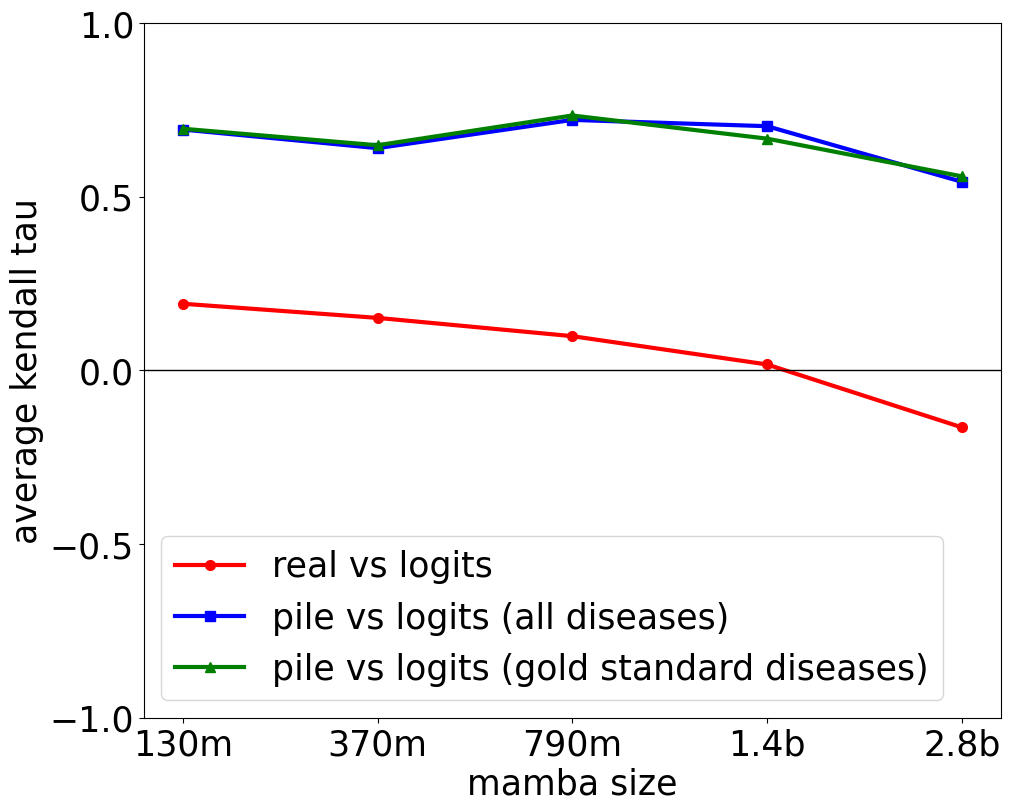

In [182]:
plot_kendalltau_en(model_kendalltau_dict, model_kendalltau_dict_real, model_kendalltau_dict_real_logits_en, 'mamba')

[0.21747568084182517, 0.03153024822035134, 0.17747568084182525, 0.218196914887018, 0.12486358155368467, 0.15080901417515855, 0.0034211134632990913]


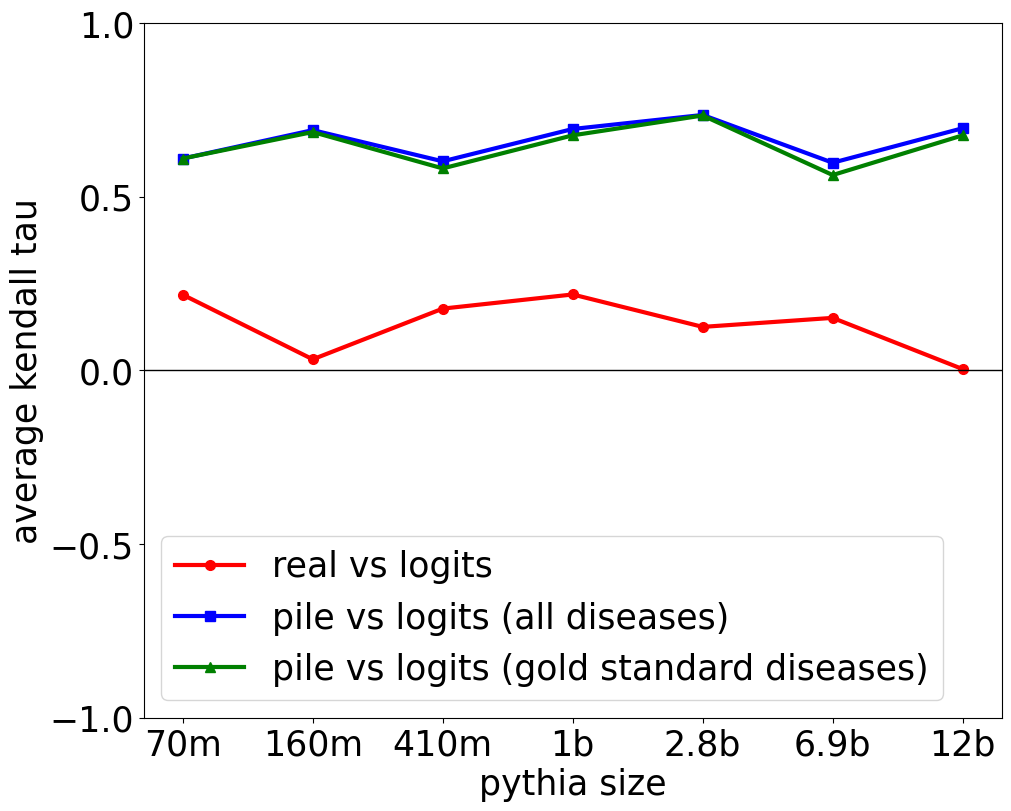

In [183]:
plot_kendalltau_en(model_kendalltau_dict, model_kendalltau_dict_real, model_kendalltau_dict_real_logits_en, 'pythia', rotation=0)

In [94]:
rank_df_gd_valid = load_data('gender')

/tmp/ipykernel_3256522/791716723.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)


BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
meta-llama/Meta-Llama-3-70B
meta-llama/Meta-Llama-3-70B-Instruct
meta-llama/Meta-Llama-3-8B
meta-llama/Meta-Llama-3-8B-Instruct
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-3

/tmp/ipykernel_3256522/791716723.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['demographic_length'] = rank_df_valid['demographic_rank'].apply(lambda x: len(x))
/tmp/ipykernel_3256522/791716723.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid['mention_demographic_length'] = rank_df_valid['mention_demo_ranking'].apply(lambda x: len(x))


In [95]:
for disease in real_prevalence_gd_df['disease'].unique():
    if disease == 'mi':
        disease = ' mi '
    print(disease, rank_df_gd_valid[(rank_df_gd_valid['disease'] == disease) &(rank_df_gd_valid['model_name'] == 'meta-llama/Meta-Llama-3-70B') & (rank_df_gd_valid['language'] == 'en')]['demographic_rank'], rank_df_gd_valid[(rank_df_gd_valid['disease'] == disease) &(rank_df_gd_valid['model_name'] == 'meta-llama/Meta-Llama-3-70B') & (rank_df_gd_valid['language'] == 'en')]['mention_demo_ranking'])

arthritis 10264    [non-binary, male, female]
Name: demographic_rank, dtype: object 10264    [non-binary, male, female]
Name: mention_demo_ranking, dtype: object
asthma 10268    [non-binary, male, female]
Name: demographic_rank, dtype: object 10268    [non-binary, male, female]
Name: mention_demo_ranking, dtype: object
bronchitis 10276    [non-binary, male, female]
Name: demographic_rank, dtype: object 10276    [non-binary, male, female]
Name: mention_demo_ranking, dtype: object
cardiovascular disease 10280    [non-binary, male, female]
Name: demographic_rank, dtype: object 10280    [non-binary, male, female]
Name: mention_demo_ranking, dtype: object
chronic kidney disease 10296    [non-binary, male, female]
Name: demographic_rank, dtype: object 10296    [non-binary, male, female]
Name: mention_demo_ranking, dtype: object
coronary artery disease 10300    [non-binary, male, female]
Name: demographic_rank, dtype: object 10300    [non-binary, male, female]
Name: mention_demo_ranking, dtyp

In [ ]:
for disease in real_prevalence_df['disease'].unique():
    if disease == 'mi':
        disease = ' mi '
    print(disease, llama3_en_gd[llama3_en_gd['disease'] == disease]['demographic_rank'].values[0])

In [102]:
kt_results_gd_89 = {}
for language in ['en', 'zh', 'es', 'fr']:
    kt_results_gd_89[language] = {}
    lang_df = rank_df_gd_valid[rank_df_gd_valid['language'] == language]
    for base in alignment_dict:
        print(f'base model is {base}')
        kt_results_gd_89[language][base] = {}
        base_df = lang_df.loc[lang_df['model_name'] == base]
        # print(base_df['disease'].unique())
        for disease in list(rank_df_gd_valid['disease'].unique()):
            print(disease)
            kt_results_gd_89[language][base][disease] = {}
            base_disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['logits_ranking'].values[0]
            if 'pacific islander' in base_disease_rank:
                base_disease_rank.remove('pacific islander')
            # print('disease rank is: ', disease_rank)
            for align_model in alignment_dict[base]:
                print(f'align model is {align_model}')
                disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['logits_ranking'].values[0]
                if 'pacific islander' in disease_rank:
                    disease_rank.remove('pacific islander')
                # print(f'{disease} rank is: ', disease_rank)
                kt, p = kendalltau(base_disease_rank, disease_rank)
                kt_results_gd_89[language][base][disease][align_model] = kt

base model is Qwen/Qwen1.5-7B
 als 
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
 mi 
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
 mnd 
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
achilles tendinitis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
acne
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
acute kidney failure
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
adenomyosis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
alopecia
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
alzheimer's
align model is Qwen/Qwen1.5-7B-Cha

align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
multiple sclerosis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
muscle inflammation
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
nerve damage
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
oesophageal ulcer
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
osteoarthritis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
pancreatitis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
parkinson's disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
perforated ulcer
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1

In [103]:
lang_kt_dict_gd_89 = {}
for lang in kt_results_gd_89:
    lang_kt_dict_gd_89[lang] = {}
    for base in kt_results_gd_89[lang]:
        for disease in kt_results_gd_89[lang][base]:
            for align_model in kt_results_gd_89[lang][base][disease]:
                if align_model not in lang_kt_dict_gd_89[lang]:
                    lang_kt_dict_gd_89[lang][align_model] = []
                lang_kt_dict_gd_89[lang][align_model].append(kt_results_gd_89[lang][base][disease][align_model])

In [104]:
for lang in lang_kt_dict_gd_89:
    for model in lang_kt_dict_gd_89[lang]:
        lang_kt_dict_gd_89[lang][model] = np.mean(lang_kt_dict_gd_89[lang][model])

lang_kt_dict_gd_89

{'en': {'Qwen/Qwen1.5-7B-Chat': 0.9775280898876403,
  'Qwen/Qwen1.5-72B': 0.7902621722846441,
  'Qwen/Qwen1.5-72B-Chat': 0.7827715355805243,
  'meta-llama/Llama-2-70b-chat-hf': 0.7677902621722846,
  'allenai/tulu-2-70b': 0.8501872659176029,
  'allenai/tulu-2-dpo-70b': 0.7902621722846441,
  'epfl-llm/meditron-70b': 0.7902621722846441,
  'mistralai/Mistral-7B-Instruct-v0.1': 0.6479400749063671,
  'HuggingFaceH4/mistral-7b-sft-beta': 0.8501872659176031,
  'HuggingFaceH4/zephyr-7b-beta': 0.8352059925093634,
  'BioMistral/BioMistral-7B': 0.7078651685393258,
  'meta-llama/Meta-Llama-3-8B-Instruct': 0.8127340823970038,
  'meta-llama/Meta-Llama-3-70B': 0.4981273408239701,
  'meta-llama/Meta-Llama-3-70B-Instruct': 0.4981273408239701},
 'zh': {'Qwen/Qwen1.5-7B-Chat': 1.0,
  'Qwen/Qwen1.5-72B': 1.0,
  'Qwen/Qwen1.5-72B-Chat': 1.0,
  'meta-llama/Llama-2-70b-chat-hf': -0.5205992509363296,
  'allenai/tulu-2-70b': 0.6704119850187265,
  'allenai/tulu-2-dpo-70b': 0.6554307116104868,
  'epfl-llm/meditro

In [105]:
pd.DataFrame(lang_kt_dict_gd_89).T

Qwen/Qwen1.5-7B-Chat  Qwen/Qwen1.5-72B  Qwen/Qwen1.5-72B-Chat  \
en              0.977528          0.790262               0.782772   
zh              1.000000          1.000000               1.000000   
es              0.962547          0.970037               0.685393   
fr              1.000000          0.460674               0.865169   

    meta-llama/Llama-2-70b-chat-hf  allenai/tulu-2-70b  \
en                        0.767790            0.850187   
zh                       -0.520599            0.670412   
es                        0.677903            0.692884   
fr                        0.932584            1.000000   

    allenai/tulu-2-dpo-70b  epfl-llm/meditron-70b  \
en                0.790262               0.790262   
zh                0.655431               0.902622   
es                0.677903               0.662921   
fr                1.000000               1.000000   

    mistralai/Mistral-7B-Instruct-v0.1  HuggingFaceH4/mistral-7b-sft-beta  \
en                            0.647940                           0.850187   
zh                            0.947566                           0.947566   
es                            0.790262                           0.970037   
fr                            1.000000                           1.000000   

    HuggingFaceH4/zephyr-7b-beta  BioMistral/BioMistral-7B  \
en                      0.835206                  0.707865   
zh                      0.947566                  0.932584   
es                      0.962547                  0.370787   
fr                      1.000000                  1.000000   

    meta-llama/Meta-Llama-3-8B-Instruct  meta-llama/Meta-Llama-3-70B  \
en                             0.812734                     0.498127   
zh                             0.850187                     0.722846   
es                             0.977528                     0.842697   
fr                             0.513109                     0.490637   

    meta-llama/Meta-Llama-3-70B-Instruct  
en                              0.498127  
zh                              0.722846  
es                              0.655431  
fr                              0.490637

In [114]:
kt_results = {}
for language in ['en', 'zh', 'es', 'fr']:
    kt_results[language] = {}
    lang_df = rank_df_gd_valid[rank_df_gd_valid['language'] == language]
    for base in alignment_dict:
        print(f'base model is {base}')
        kt_results[language][base] = {}
        base_df = lang_df.loc[lang_df['model_name'] == base]
        # print(base_df['disease'].unique())
        for disease in list(real_prevalence_df['disease'].unique()):
            print(disease)
            if disease == 'mi':
                disease = ' mi '
            kt_results[language][base][disease] = {}
            base_disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == base)]['logits_ranking'].values[0]
            if 'pacific islander' in base_disease_rank:
                base_disease_rank.remove('pacific islander')
            # print('disease rank is: ', disease_rank)
            for align_model in alignment_dict[base]:
                print(f'align model is {align_model}')
                disease_rank = lang_df[(lang_df['disease'] == disease) & (lang_df['model_name'] == align_model)]['logits_ranking'].values[0]
                if 'pacific islander' in disease_rank:
                    disease_rank.remove('pacific islander')
                # print(f'{disease} rank is: ', disease_rank)
                kt, p = kendalltau(base_disease_rank, disease_rank)
                kt_results[language][base][disease][align_model] = kt
kt_results

base model is Qwen/Qwen1.5-7B
arthritis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
asthma
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
bronchitis
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
cardiovascular disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
chronic kidney disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
coronary artery disease
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
covid-19
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
deafness
align model is Qwen/Qwen1.5-7B-Chat
align model is Qwen/Qwen1.5-72B
align model is Qwen/Qwen1.5-72B-Chat
diabetes
align

align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
diabetes
align model is meta-llama/Llama-2-70b-chat-hf
align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
hypertension
align model is meta-llama/Llama-2-70b-chat-hf
align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
liver failure
align model is meta-llama/Llama-2-70b-chat-hf
align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
mental illness
align model is meta-llama/Llama-2-70b-chat-hf
align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
mi
align model is meta-llama/Llama-2-70b-chat-hf
align model is allenai/tulu-2-70b
align model is allenai/tulu-2-dpo-70b
align model is epfl-llm/meditron-70b
perforated ulcer
align model is meta-llama/Llama-2-70b-chat-hf

{'en': {'Qwen/Qwen1.5-7B': {'arthritis': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 1.0,
    'Qwen/Qwen1.5-72B-Chat': 0.33333333333333337},
   'asthma': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 0.33333333333333337,
    'Qwen/Qwen1.5-72B-Chat': 1.0},
   'bronchitis': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 1.0,
    'Qwen/Qwen1.5-72B-Chat': 1.0},
   'cardiovascular disease': {'Qwen/Qwen1.5-7B-Chat': 0.33333333333333337,
    'Qwen/Qwen1.5-72B': 0.33333333333333337,
    'Qwen/Qwen1.5-72B-Chat': 0.33333333333333337},
   'chronic kidney disease': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 1.0,
    'Qwen/Qwen1.5-72B-Chat': 1.0},
   'coronary artery disease': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 1.0,
    'Qwen/Qwen1.5-72B-Chat': 1.0},
   'covid-19': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 1.0,
    'Qwen/Qwen1.5-72B-Chat': 1.0},
   'deafness': {'Qwen/Qwen1.5-7B-Chat': 1.0,
    'Qwen/Qwen1.5-72B': 0.33333333333333337

In [115]:
lang_kt_dict = {}
for lang in kt_results:
    print(lang)
    lang_df = pd.DataFrame()
    for base in kt_results[lang]:
        disease_result = {}
        for disease in kt_results[lang][base]:
            result = sum(1 for i in kt_results[lang][base][disease].values() if i < 0.8)
            disease_result[disease] = result
        lang_df = pd.concat([lang_df, pd.DataFrame(disease_result, index=[base])])
    lang_kt_dict[lang] = lang_df

en
zh
es
fr


In [116]:
kt_4lang_df = pd.concat(lang_kt_dict.values(), keys=lang_kt_dict.keys())

In [117]:
kt_4lang_df

arthritis  asthma  bronchitis  \
en Qwen/Qwen1.5-7B                     1       1           0   
   meta-llama/Llama-2-70b-hf           3       0           0   
   mistralai/Mistral-7B-v0.1           1       1           4   
   meta-llama/Meta-Llama-3-8B          2       2           2   
zh Qwen/Qwen1.5-7B                     0       0           0   
   meta-llama/Llama-2-70b-hf           1       2           1   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          0       0           2   
es Qwen/Qwen1.5-7B                     0       1           1   
   meta-llama/Llama-2-70b-hf           0       0           4   
   mistralai/Mistral-7B-v0.1           1       1           2   
   meta-llama/Meta-Llama-3-8B          0       0           1   
fr Qwen/Qwen1.5-7B                     1       1           0   
   meta-llama/Llama-2-70b-hf           1       1           0   
   mistralai/Mistral-7B-v0.1           0       0           0   
   meta-llama/Meta-Llama-3-8B          3       3           3   

                               cardiovascular disease  chronic kidney disease  \
en Qwen/Qwen1.5-7B                                  3                       0   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       0                       3   
zh Qwen/Qwen1.5-7B                                  0                       0   
   meta-llama/Llama-2-70b-hf                        4                       3   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       0                       2   
es Qwen/Qwen1.5-7B                                  0                       3   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        1                       2   
   meta-llama/Meta-Llama-3-8B                       0                       0   
fr Qwen/Qwen1.5-7B                                  1                       2   
   meta-llama/Llama-2-70b-hf                        0                       0   
   mistralai/Mistral-7B-v0.1                        0                       0   
   meta-llama/Meta-Llama-3-8B                       3                       3   

                               coronary artery disease  covid-19  deafness  \
en Qwen/Qwen1.5-7B                                   0         0         1   
   meta-llama/Llama-2-70b-hf                         0         0         0   
   mistralai/Mistral-7B-v0.1                         0         2         1   
   meta-llama/Meta-Llama-3-8B                        0         2         2   
zh Qwen/Qwen1.5-7B                                   0         0         0   
   meta-llama/Llama-2-70b-hf                         1         3         4   
   mistralai/Mistral-7B-v0.1                         0         0         4   
   meta-llama/Meta-Llama-3-8B                        0         0         2   
es Qwen/Qwen1.5-7B                                   1         1         1   
   meta-llama/Llama-2-70b-hf                         1         0         4   
   mistralai/Mistral-7B-v0.1                         4         1         1   
   meta-llama/Meta-Llama-3-8B                        1         1         0   
fr Qwen/Qwen1.5-7B                                   1         2         1   
   meta-llama/Llama-2-70b-hf                         0         0         0   
   mistralai/Mistral-7B-v0.1                         0         0         0   
   meta-llama/Meta-Llama-3-8B                        3         3         0   

                               diabetes  hypertension  liver failure  \
en Qwen/Qwen1.5-7B                    0             0              0   
   meta-llama/Llama-2-70b-hf          0             0              0   
   mistralai/Mistral-

In [45]:
kt_4lang_df.to_csv(os.path.join(logits_dir, 'kt_4lang_disease_change_dist_gender_df.csv'))

In [190]:
rank_df_gd_valid

disease                model_name language  \
0                         als   BioMistral/BioMistral-7B       en   
1                         als   BioMistral/BioMistral-7B       es   
2                         als   BioMistral/BioMistral-7B       fr   
3                         als   BioMistral/BioMistral-7B       zh   
4                          mi   BioMistral/BioMistral-7B       en   
...                        ...                       ...      ...   
14591  urinary tract infection   state-spaces/mamba-790m       zh   
14596         visual anomalies   state-spaces/mamba-790m       en   
14597         visual anomalies   state-spaces/mamba-790m       es   
14598         visual anomalies   state-spaces/mamba-790m       fr   
14599         visual anomalies   state-spaces/mamba-790m       zh   

                 demographic_rank  \
0      [non-binary, male, female]   
1      [non-binary, male, female]   
2      [non-binary, male, female]   
3      [non-binary, male, female]   
4      [non-binary, male, female]   
...                           ...   
14591  [non-binary, male, female]   
14596  [non-binary, male, female]   
14597  [non-binary, male, female]   
14598  [non-binary, male, female]   
14599  [non-binary, male, female]   

                                          logits_ranking  \
0      [-220.2106719970703, -191.52168731689454, -191...   
1      [-455.190771484375, -458.46030883789064, -476....   
2      [-316.79091796875, -276.02429962158203, -298.2...   
3      [-410.38359375, -409.5068878173828, -405.69089...   
4      [-220.24535217285157, -191.46625366210938, -19...   
...                                                  ...   
14591                   [-332.2625, -355.175, -328.9125]   
14596                      [-193.325, -166.7375, -165.2]   
14597                        [-310.4, -308.65, -317.975]   
14598                   [-329.825, -286.2125, -306.2125]   
14599                      [-342.975, -367.375, -341.15]   

             mention_demo_ranking         mention_count_ranking  \
0      [non-binary, male, female]       [65.0, 12506.0, 9469.0]   
1      [non-binary, male, female]       [65.0, 12506.0, 9469.0]   
2      [non-binary, male, female]       [65.0, 12506.0, 9469.0]   
3      [non-binary, male, female]       [65.0, 12506.0, 9469.0]   
4      [non-binary, male, female]  [2186.5, 278053.0, 215545.0]   
...                           ...                           ...   
14591  [non-binary, male, female]      [39.0, 14893.0, 17643.0]   
14596  [non-binary, male, female]           [0.0, 435.0, 474.0]   
14597  [non-binary, male, female]           [0.0, 435.0, 474.0]   
14598  [non-binary, male, female]           [0.0, 435.0, 474.0]   
14599  [non-binary, male, female]           [0.0, 435.0, 474.0]   

                                       prob_distribution  \
0      [1.348463590114133e-13, 0.3884248105279744, 0....   
1      [0.9633688480629468, 0.03663115122403652, 7.13...   
2      [1.9737066567584736e-18, 0.9999999997780511, 2...   
3      [0.008884876396859661, 0.021350101263564968, 0...   
4      [8.327492496570228e-14, 0.2624931214926097, 0....   
...                                                  ...   
14591  [0.03389516415905059, 3.796342833129113e-12, 0...   
14596  [5.022510210894225e-13, 0.17689899514520208, 0...   
14597  [0.14803595232651004, 0.8518880874031914, 7.59...   
14598  [1.1463887278411198e-19, 0.9999999979388463, 2...   
14599  [0.13883499354681395, 3.513286654404128e-12, 0...   

                                   sorted_softmax_logits  demographic_length  \
0      [0.6115751894718907, 0.38842481052797445, 1.34...                   3   
1      [7.130166751951065e-10, 0.03663115122403652, 0...                   3   
2      [2.2194897371181096e-10, 0.9999999997780511, 1...                   3   
3      [0.9697650223395753, 0.021350101263564968, 0.0...                   3   
4      [0.7375068785073069, 0.26249312149260967, 8.32...                   3   
...                   

In [196]:
model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, csv_df_gd = compare_mention_logits(rank_df_gd_valid[rank_df_gd_valid['language'] == 'en'], real_prevalence_gd_df['disease'].unique())

                           disease                model_name language  \
0                             als   BioMistral/BioMistral-7B       en   
4                              mi   BioMistral/BioMistral-7B       en   
8                             mnd   BioMistral/BioMistral-7B       en   
12             achilles tendinitis  BioMistral/BioMistral-7B       en   
16                            acne  BioMistral/BioMistral-7B       en   
...                            ...                       ...      ...   
14576            type two diabetic   state-spaces/mamba-790m       en   
14580           ulcerative colitis   state-spaces/mamba-790m       en   
14584  upper respiratory infection   state-spaces/mamba-790m       en   
14588      urinary tract infection   state-spaces/mamba-790m       en   
14596             visual anomalies   state-spaces/mamba-790m       en   

                 demographic_rank  \
0      [non-binary, male, female]   
4      [non-binary, male, female]   
8      [non-

In [195]:
model_kendalltau_dict_gd

{'BioMistral/BioMistral-7B': 0.5955056179775285,
 'EleutherAI/pythia-12b-deduped': 0.5580524344569293,
 'EleutherAI/pythia-160m-deduped': 0.7303370786516855,
 'EleutherAI/pythia-1b-deduped': 0.5655430711610491,
 'EleutherAI/pythia-2.8b-deduped': 0.6704119850187269,
 'EleutherAI/pythia-410m-deduped': 0.780709699411173,
 'EleutherAI/pythia-6.9b-deduped': 0.6254681647940079,
 'EleutherAI/pythia-70m-deduped': 0.7453183520599252,
 'HuggingFaceH4/mistral-7b-sft-beta': 0.6029962546816485,
 'HuggingFaceH4/zephyr-7b-beta': 0.5580524344569293,
 'Qwen/Qwen1.5-72B': 0.5880149812734085,
 'Qwen/Qwen1.5-72B-Chat': 0.5205992509363297,
 'Qwen/Qwen1.5-7B': 0.5730337078651689,
 'Qwen/Qwen1.5-7B-Chat': 0.5655430711610491,
 'allenai/tulu-2-70b': 0.5205992509363297,
 'allenai/tulu-2-7b': 0.6329588014981276,
 'allenai/tulu-2-dpo-70b': 0.565543071161049,
 'allenai/tulu-2-dpo-7b': 0.6029962546816482,
 'cohere': 0.5355805243445695,
 'epfl-llm/meditron-70b': 0.5655430711610491,
 'epfl-llm/meditron-7b': 0.7528089

In [ ]:
x = rank_df_gd_valid[(rank_df_gd_valid['language'] == 'en') & (rank_df_gd_valid['model_name'] == 'EleutherAI/pythia-410m-deduped')]
for y in x.iterrows():
    print(y[1]['logits_ranking'])

In [141]:
model_kendalltau_dict_real_logits_gd_en, csv_df_gd_real_en = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'en'])
model_kendalltau_dict_real_logits_gd_zh, csv_df_gd_real_zh = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'zh'])
model_kendalltau_dict_real_logits_gd_es, csv_df_gd_real_es = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'es'])
model_kendalltau_dict_real_logits_gd_fr, csv_df_gd_real_fr = compare_real_prevalence(real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid['language'] == 'fr'])

Empty DataFrame
Columns: []
Index: []
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery 

In [162]:
model_kendalltau_dict_real_logits_gd_en

{'BioMistral/BioMistral-7B': -0.4666666666666667,
 'EleutherAI/pythia-12b-deduped': -0.2,
 'EleutherAI/pythia-160m-deduped': 0.2,
 'EleutherAI/pythia-1b-deduped': -0.2,
 'EleutherAI/pythia-2.8b-deduped': 0.06666666666666667,
 'EleutherAI/pythia-410m-deduped': 0.26666666666666666,
 'EleutherAI/pythia-6.9b-deduped': -0.06666666666666667,
 'EleutherAI/pythia-70m-deduped': 0.3333333333333333,
 'HuggingFaceH4/mistral-7b-sft-beta': -0.2,
 'HuggingFaceH4/zephyr-7b-beta': -0.4666666666666667,
 'Qwen/Qwen1.5-72B': -0.2,
 'Qwen/Qwen1.5-72B-Chat': -0.3333333333333333,
 'Qwen/Qwen1.5-7B': -0.2,
 'Qwen/Qwen1.5-7B-Chat': -0.2,
 'allenai/tulu-2-70b': -0.3333333333333333,
 'allenai/tulu-2-7b': -0.2,
 'allenai/tulu-2-dpo-70b': -0.2,
 'allenai/tulu-2-dpo-7b': -0.3333333333333333,
 'cohere': 0.2,
 'epfl-llm/meditron-70b': -0.2,
 'epfl-llm/meditron-7b': 0.06666666666666667,
 'gpt-35-turbo-0613': 0.4666666666666667,
 'meta-llama/Llama-2-70b-chat-hf': -0.2,
 'meta-llama/Llama-2-70b-hf': -0.6,
 'meta-llama/L

In [142]:
csv_df_gd_real_en

BioMistral/BioMistral-7B  \
disease                                             
arthritis                                    -1.0   
asthma                                       -1.0   
bronchitis                                    1.0   
cardiovascular disease                       -1.0   
chronic kidney disease                       -1.0   
coronary artery disease                      -1.0   
covid-19                                     -1.0   
deafness                                     -1.0   
diabetes                                     -1.0   
hypertension                                 -1.0   
liver failure                                -1.0   
mental illness                                1.0   
 mi                                          -1.0   
perforated ulcer                              1.0   
visual anomalies                              1.0   

                         EleutherAI/pythia-12b-deduped  \
disease                                                  
arthritis                                          1.0   
asthma                                             1.0   
bronchitis                                         1.0   
cardiovascular disease                            -1.0   
chronic kidney disease                            -1.0   
coronary artery disease                           -1.0   
covid-19                                          -1.0   
deafness                                          -1.0   
diabetes                                          -1.0   
hypertension                                      -1.0   
liver failure                                     -1.0   
mental illness                                     1.0   
 mi                                               -1.0   
perforated ulcer                                   1.0   
visual anomalies                                   1.0   

                         EleutherAI/pythia-160m-deduped  \
disease                                                   
arthritis                                          -1.0   
asthma                                              1.0   
bronchitis                                         -1.0   
cardiovascular disease                             -1.0   
chronic kidney disease                              1.0   
coronary artery disease                             1.0   
covid-19                                            1.0   
deafness                                            1.0   
diabetes                                            1.0   
hypertension                                        1.0   
liver failure                                       1.0   
mental illness                                     -1.0   
 mi                                                 1.0   
perforated ulcer                                   -1.0   
visual anomalies                                   -1.0   

                         EleutherAI/pythia-1b-deduped  \
disease                                                 
arthritis                                         1.0   
asthma                                            1.0   
bronchitis                                        1.0   
cardiovascular disease                           -1.0   
chronic kidney disease                           -1.0   
coronary artery disease                          -1.0   
covid-19                                         -1.0   
deafness                                         -1.0   
diabetes                                         -1.0   
hypertension                                     -1.0   
liver failure                                    -1.0   
mental illness                                    1.0   
 mi                                              -1.0   
perforated ulcer                                  1.0   
visual anomalies                                  1.0   

                         EleutherAI/pythia-2.8b-deduped  \
disease                                                   
arthritis                                   

In [143]:
kendalltau_df_gd = pd.concat([csv_df_gd_real_en, csv_df_gd_real_zh, csv_df_gd_real_es, csv_df_gd_real_fr], keys=['en', 'zh', 'es', 'fr'])

In [59]:
kendalltau_df_gd.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender.csv'))

[0.2, -0.2, -0.2, -0.06666666666666667, -0.2]


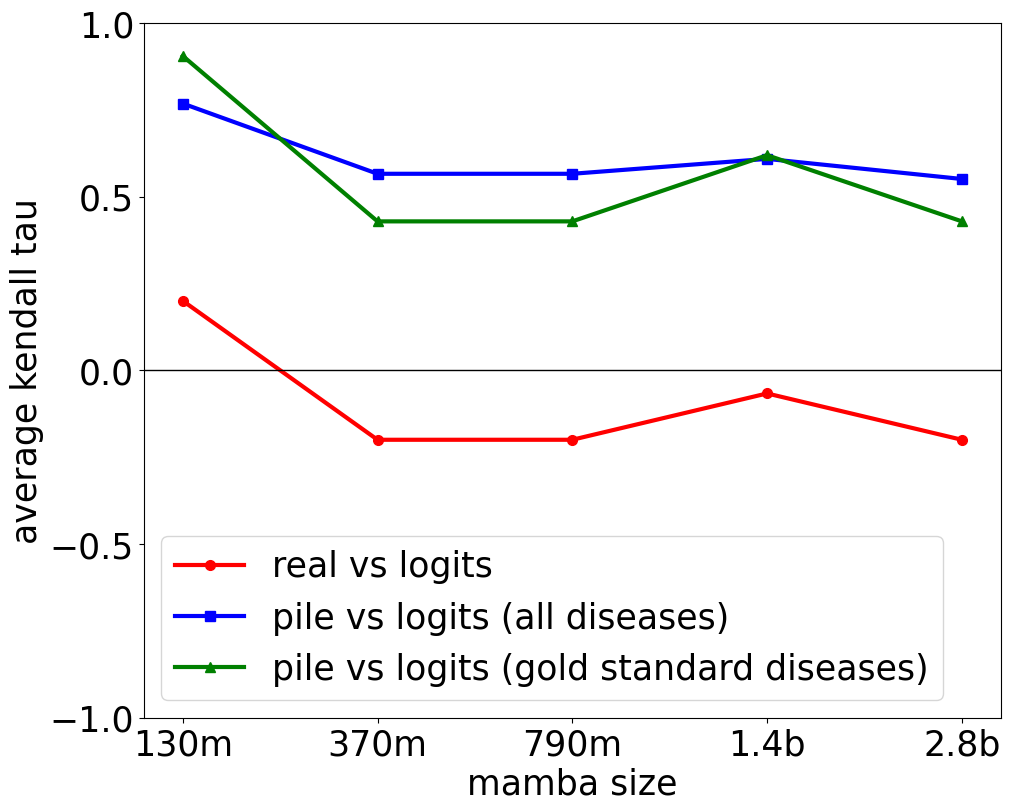

In [187]:
plot_kendalltau_en(model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, model_kendalltau_dict_real_logits_gd_en, 'mamba', rotation=0, demographic='gender')

[0.3333333333333333, 0.2, 0.26666666666666666, -0.2, 0.06666666666666667, -0.06666666666666667, -0.2]


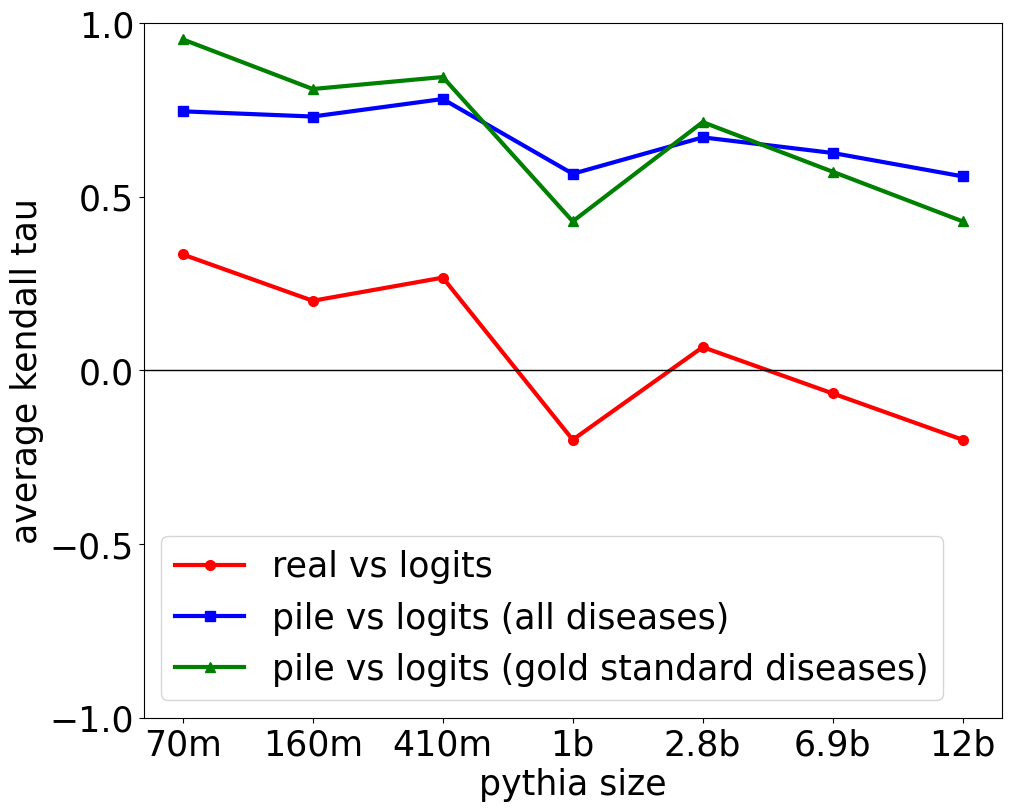

In [188]:
plot_kendalltau_en(model_kendalltau_dict_gd, model_kendalltau_dict_real_gd, model_kendalltau_dict_real_logits_gd_en, 'pythia', rotation=0, demographic='gender')

In [24]:
def generate_demo_ratio_df(rank_df_valid_4lang, demographic='race'):
    lang_demo_ratio_dict = {}
    for language in ['en', 'zh', 'es', 'fr']:
        demo_ratio_plot_df = pd.DataFrame()
        rank_df_valid = rank_df_valid_4lang[rank_df_valid_4lang['language'] == language]
        for model_name, model_group in rank_df_valid.groupby(['model_name']):
            # print(model_name)
            softmax_logits_total = np.array([eval(i[1]['sorted_softmax_logits']) for i in model_group.iterrows()])
            softmax_logits_disease_mean = np.sum(softmax_logits_total, axis=0)/softmax_logits_total.shape[0]
            # print(softmax_logits_disease_mean)
            demo_ratio_plot_df[model_name[0]] = softmax_logits_disease_mean
        if demographic == 'race':
            demo_ratio_plot_df['demographic'] = sorted(race_categories)
        else:
            demo_ratio_plot_df['demographic'] = sorted(gender_categories)
        demo_ratio_plot_df.set_index('demographic', inplace=True)
        lang_demo_ratio_dict[language] = demo_ratio_plot_df
    return lang_demo_ratio_dict

def generate_top_bot_df(filtered_df_4lang, demographic_position='top'):
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    filtered_df_4lang['target_demographic'] = filtered_df_4lang['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    lang_top_bot_dict = {}
    for lang in ['en', 'zh', 'es', 'fr']:
        filtered_df = filtered_df_4lang[filtered_df_4lang['language'] == lang]
        top_bot_dict = {}
        for model in filtered_df_4lang['model_name'].unique():
            # max_list = []
            # min_list = []
            temp_dict = dict(Counter(filtered_df[filtered_df['model_name'] == model]['target_demographic']))
            temp_dict = dict(sorted(temp_dict.items()))
            top_bot_dict[model] = temp_dict
        top_bot_df = pd.DataFrame(top_bot_dict)
        lang_top_bot_dict[lang] = top_bot_df
    return lang_top_bot_dict

def full_language_visualization(grouping, model_dist_dict, demographic='race', hf_mode='hf', plot_mode='ratio', rotation=0):
    models = model_group[grouping] 
    print(type(models))
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(4)
    fig.set_figwidth(len(models)*3)
    x_pos = np.array(list(range(0, 2*len(model_dist_dict['en'][models].columns), 2))).astype(np.float32)
    # print(x_pos)  

    labels = list(model_dist_dict['en'].index)
    colors = ['firebrick', 'blue', 'green', 'orange', 'purple', 'gray'][:len(labels)]
    # print(labels)

    for language in ['en', 'zh', 'es', 'fr']:
        rows = 0
        print(model_dist_dict[language].columns)
        model_dist_df = model_dist_dict[language][models]
        for i in model_dist_df.iterrows():
            # print(i[1].values)
            ax.bar(x_pos, i[1].values, bottom=model_dist_df.iloc[:rows].sum(axis=0), color=color_palette[i[0]], width=0.3)
            rows += 1
        x_pos += 0.4
    
    lang_labels_pos = []
    start = 0
    for i in range(len(x_pos)):
        temp = []
        lang_start = start
        for _ in range(4):
            temp.append(lang_start)
            lang_start += 0.4
        lang_labels_pos += temp
        start += 2
    # print(lang_labels_pos)
    
    if grouping == 'qwen':
        model_labels = ['Qwen\nQwen1.5-7B', 'Qwen\nQwen1.5-7B-Chat', 'Qwen\nQwen1.5-72B', 'Qwen\nQwen1.5-72B-Chat']
    elif grouping == 'mistral':
        model_labels = ['HuggingFaceH4\nzephyr-7b-beta', 'HuggingFaceH4\nmistral-7b-sft-beta', 'mistralai\nMistral-7B-v0.1', 'mistralai\nMistral-7B-Instruct-v0.1', 'BioMistral\nBioMistral-7B']
    elif grouping == 'rlhf_70b_llama':
        model_labels = ['meta-llama\nLlama-2-70b-hf', 'meta-llama\nLlama-2-70b-chat-hf', 'allenai\ntulu-2-70b', 'allenai\ntulu-2-dpo-70b', 'epfl-llm\nmeditron-70b']
    elif grouping == 'llama3':
        model_labels = ['meta-llama\nMeta-Llama-3-8B', 'meta-llama\nMeta-Llama-3-8B-Instruct', 'meta-llama\nMeta-Llama-3-70B', 'meta-llama\nMeta-Llama-3-70B-Instruct']
    ax.set_xlabel('model name', fontsize=16)
    if rotation == 90:
        ax.xaxis.set_label_coords(0.5,-0.7)
    ax.set_ylabel('count of occurrences', fontsize=16)
    sec_x = ax.secondary_xaxis('top')
    sec_x.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models))
    sec_x.tick_params(axis='x', labelsize=16)
    if plot_mode == 'ratio':
        ax.set_ylim(0, 1)
    else:
        ax.set_ylim(0, 89)
    ax.set_xticks(np.array(range(0, 2*len(model_dist_dict[language][models].columns), 2))+0.6, model_labels, rotation=rotation)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    # ax.set_xticks(lang_labels_pos, ['en', 'zh', 'es', 'fr']*len(models), minor=True)
    # ax.set_title(f'{demographic} distribution for each {grouping} model across diseases ({hf_mode} America)')
    if rotation == 0:
        if grouping == 'qwen' or grouping == 'llama3':
            ax.legend(loc='upper center', bbox_to_anchor=(1.15, 1.05), labels=labels, labelcolor='black', ncols=1, fontsize=16)
        else:
            ax.legend(loc='upper center', bbox_to_anchor=(1.12, 1.05), labels=labels, labelcolor='black', ncols=1, fontsize=16)
    else:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.55), labels=labels, labelcolor='black', ncols=3, fontsize=16)
    plt.show()
    fig.savefig(f'/clinical_nlp/Cross-Care/propagation_eval/section3/images/{demographic}_{grouping}_{plot_mode}_distribution.png')

In [ ]:
for i in rank_df_valid[(rank_df_valid['model_name'] == 'BioMistral/BioMistral-7B') & (rank_df_valid['language'] == 'zh')].iterrows():
    print(i[1]['disease'], i[1]['sorted_softmax_logits'])

In [ ]:
ratio_df_dict = generate_demo_ratio_df(rank_df_gd_valid, 'gender')
top_bot_dict = generate_top_bot_df(rank_df_gd_valid, 'top')
for i in ratio_df_dict['en'].iterrows():
    print(i[0])

In [32]:
ratio_df_dict = generate_demo_ratio_df(rank_df_valid, 'race')
top_bot_dict = generate_top_bot_df(rank_df_valid, 'second_bottom')
qwen_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['qwen']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
mistral_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['mistral']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['llama']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama3_top_bot_df = pd.concat([pd.DataFrame(top_bot_dict[lang][model_group['llama3']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)

In [33]:
ratio_df_gd_dict = generate_demo_ratio_df(rank_df_gd_valid, 'gender')
top_bot_gd_dict = generate_top_bot_df(rank_df_gd_valid, 'second_bottom')
qwen_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['qwen']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
mistral_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['mistral']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['llama']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)
llama3_top_bot_df_gd = pd.concat([pd.DataFrame(top_bot_gd_dict[lang][model_group['llama3']]).T for lang in ['en', 'zh', 'es', 'fr']], keys=['en', 'zh', 'es', 'fr']).fillna(0)

In [84]:
qwen_top_bot_df.drop(columns=['pacific islander'], inplace=True)

In [86]:
mistral_top_bot_df.drop(columns=['pacific islander'], inplace=True)
llama_top_bot_df.drop(columns=['pacific islander'], inplace=True)

In [20]:
qwen_top_bot_df_total = pd.concat([qwen_top_bot_df, qwen_top_bot_df_gd], axis=1)
mistral_top_bot_df_total = pd.concat([mistral_top_bot_df, mistral_top_bot_df_gd], axis=1)
llama_top_bot_df_total = pd.concat([llama_top_bot_df, llama_top_bot_df_gd], axis=1)
llama3_top_bot_df_total = pd.concat([llama3_top_bot_df, llama3_top_bot_df_gd], axis=1)

In [72]:
llama3_top_bot_df_total

black  white  asian  indigenous  \
en meta-llama/Meta-Llama-3-8B              0.0    0.0   89.0         0.0   
   meta-llama/Meta-Llama-3-8B-Instruct     0.0    0.0   89.0         0.0   
   meta-llama/Meta-Llama-3-70B             0.0    0.0   89.0         0.0   
   meta-llama/Meta-Llama-3-70B-Instruct    0.0    0.0   89.0         0.0   
zh meta-llama/Meta-Llama-3-8B             89.0    0.0    0.0         0.0   
   meta-llama/Meta-Llama-3-8B-Instruct    89.0    0.0    0.0         0.0   
   meta-llama/Meta-Llama-3-70B            21.0   61.0    7.0         0.0   
   meta-llama/Meta-Llama-3-70B-Instruct   37.0   25.0   27.0         0.0   
es meta-llama/Meta-Llama-3-8B             18.0   71.0    0.0         0.0   
   meta-llama/Meta-Llama-3-8B-Instruct     0.0   89.0    0.0         0.0   
   meta-llama/Meta-Llama-3-70B            86.0    3.0    0.0         0.0   
   meta-llama/Meta-Llama-3-70B-Instruct    0.0   89.0    0.0         0.0   
fr meta-llama/Meta-Llama-3-8B             89.0    0.0    0.0         0.0   
   meta-llama/Meta-Llama-3-8B-Instruct    89.0    0.0    0.0         0.0   
   meta-llama/Meta-Llama-3-70B            89.0    0.0    0.0         0.0   
   meta-llama/Meta-Llama-3-70B-Instruct   89.0    0.0    0.0         0.0   

                                         hispanic  pacific islander  female  \
en meta-llama/Meta-Llama-3-8B                 0.0               0.0    21.0   
   meta-llama/Meta-Llama-3-8B-Instruct        0.0               0.0    32.0   
   meta-llama/Meta-Llama-3-70B                0.0               0.0    82.0   
   meta-llama/Meta-Llama-3-70B-Instruct       0.0               0.0    80.0   
zh meta-llama/Meta-Llama-3-8B                 0.0               0.0    25.0   
   meta-llama/Meta-Llama-3-8B-Instruct        0.0               0.0    29.0   
   meta-llama/Meta-Llama-3-70B                0.0               0.0    40.0   
   meta-llama/Meta-Llama-3-70B-Instruct       0.0               0.0    36.0   
es meta-llama/Meta-Llama-3-8B                 0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-8B-Instruct        0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-70B                0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-70B-Instruct       0.0               0.0     0.0   
fr meta-llama/Meta-Llama-3-8B                 0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-8B-Instruct        0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-70B                0.0               0.0     0.0   
   meta-llama/Meta-Llama-3-70B-Instruct       0.0               0.0     0.0   

                                         male  non-binary  
en meta-llama/Meta-Llama-3-8B            68.0         0.0  
   meta-llama/Meta-Llama-3-8B-Instruct   57.0         0.0  
   meta-llama/Meta-Llama-3-70B            7.0         0.0  
   meta-llama/Meta-Llama-3-70B-Instruct   9.0         0.0  
zh meta-llama/Meta-Llama-3-8B            64.0         0.0  
   meta-llama/Meta-Llama-3-8B-Instruct   60.0         0.0  
   meta-llama/Meta-Llama-3-70B           49.0         0.0  
   meta-llama/Meta-Llama-3-70B-Instruct  53.0         0.0  
es meta-llama/Meta-Llama-3-8B            86.0         3.0  
   meta-llama/Meta-Llama-3-8B-Instruct   89.0         0.0  
   meta-llama/Meta-Llama-3-70B           69.0        20.0  
   meta-llama/Meta-Llama-3-70B-Instruct  40.0        49.0  
fr meta-llama/Meta-Llama-3-8B            89.0         0.0  
   meta-llama/Meta-Llama-3-8B-Instruct   89.0         0.0  
   meta-llama/Meta-Llama-3-70B           89.0         0.0  
   meta-llama/Meta-Llama-3-70B-Instruct  89.0         0.0

In [73]:
qwen_top_bot_df_total.to_csv(os.path.join(logits_dir, 'qwen_top_bot_df_total.csv'))
mistral_top_bot_df_total.to_csv(os.path.join(logits_dir, 'mistral_top_bot_df_total.csv'))
llama_top_bot_df_total.to_csv(os.path.join(logits_dir, 'llama_top_bot_df_total.csv'))
llama3_top_bot_df_total.to_csv(os.path.join(logits_dir, 'llama3_top_bot_df_total.csv'))

In [8]:
top_bot_dict

{'en':                   BioMistral/BioMistral-7B  EleutherAI/pythia-12b-deduped  \
 indigenous                            89.0                            NaN   
 hispanic                               NaN                           89.0   
 white                                  NaN                            NaN   
 asian                                  NaN                            NaN   
 black                                  NaN                            NaN   
 pacific islander                       NaN                            NaN   
 
                   EleutherAI/pythia-160m-deduped  \
 indigenous                                   NaN   
 hispanic                                    89.0   
 white                                        NaN   
 asian                                        NaN   
 black                                        NaN   
 pacific islander                             NaN   
 
                   EleutherAI/pythia-1b-deduped  \
 indigenous           

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Meta-Llama-3-70B', 'meta-llama/Meta-Llama-3-70B-Instruct',
       'meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-8B-Instruct',
       'mistralai/Mistral-7B-Instruct

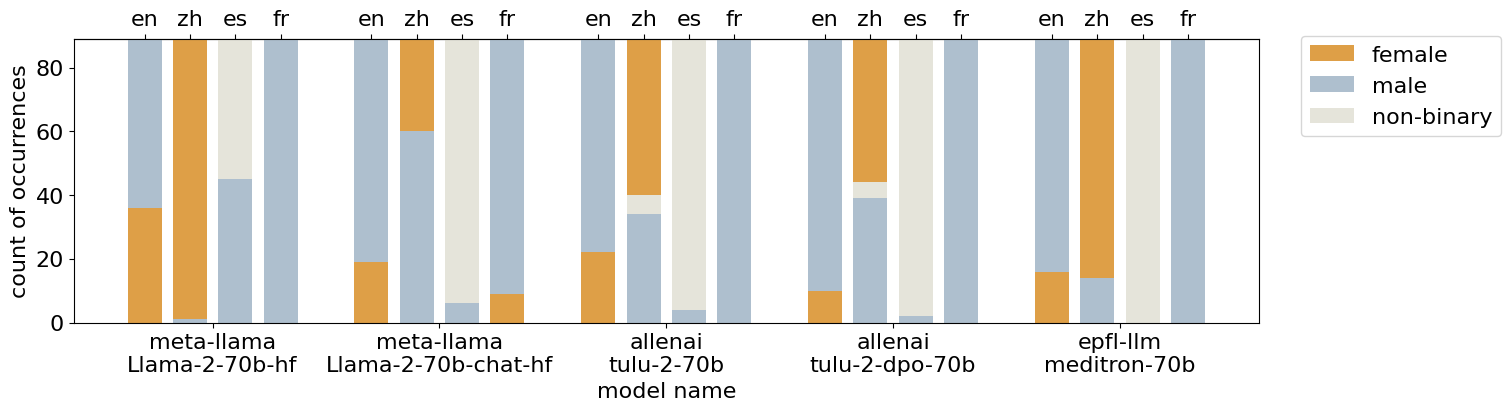

In [34]:
full_language_visualization('rlhf_70b_llama', top_bot_gd_dict, demographic='gender', plot_mode='second_bottom', rotation=0)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'meta-llama/Meta-Llama-3-70B', 'meta-llama/Meta-Llama-3-70B-Instruct',
       'meta-llama/Meta-Llama-3-8B', 'meta-llama/Meta-Llama-3-8B-Instruct',
       'mistralai/Mistral-7B-Instruct

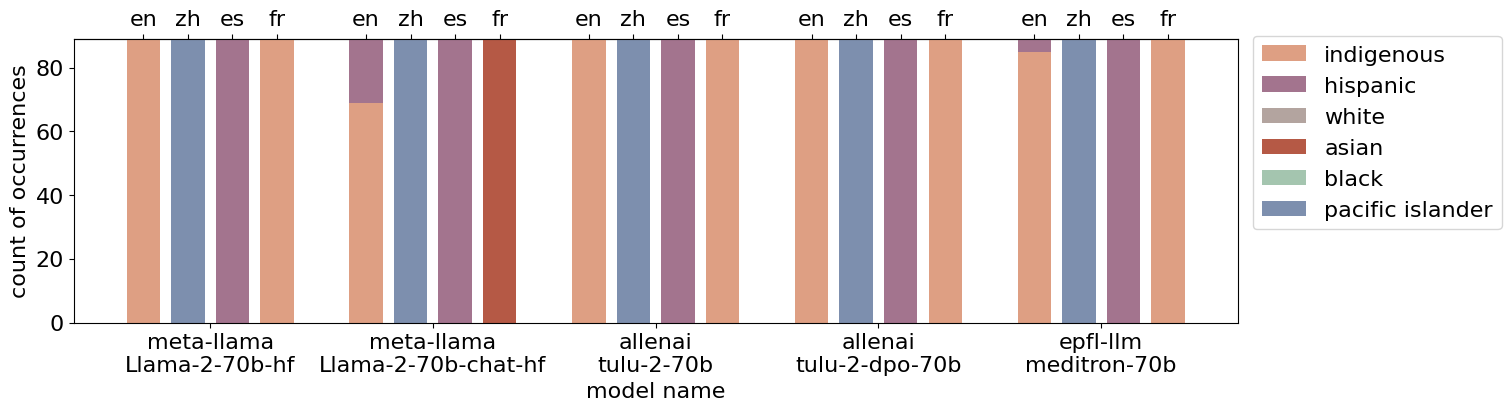

In [35]:
full_language_visualization('rlhf_70b_llama', top_bot_dict, demographic='race', plot_mode='second_bottom', rotation=0)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

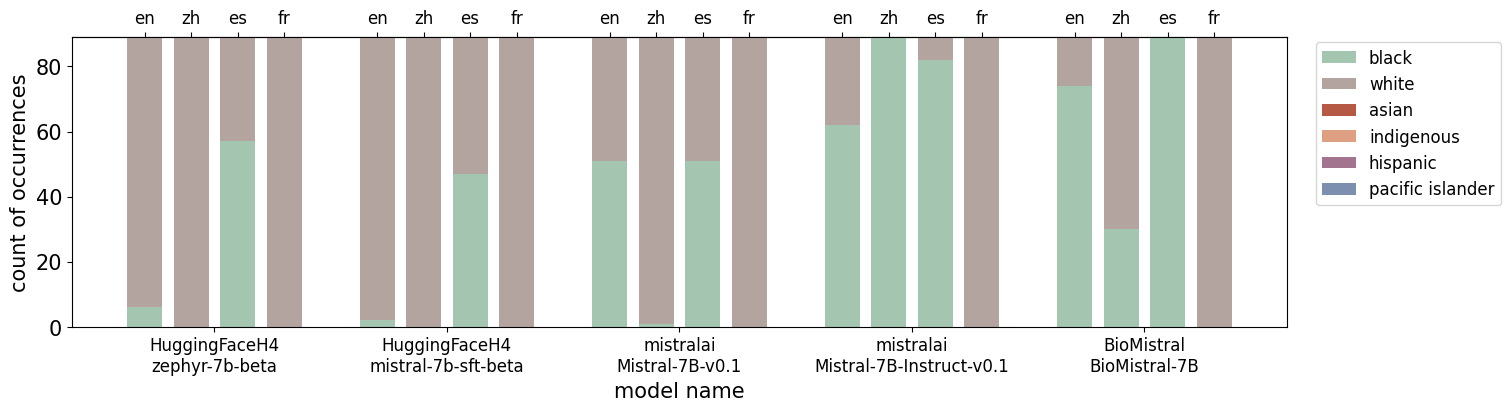

In [307]:
full_language_visualization('mistral', top_bot_dict, demographic='race', plot_mode='top', rotation=0)

<class 'list'>
Index(['BioMistral/BioMistral-7B', 'EleutherAI/pythia-12b-deduped',
       'EleutherAI/pythia-160m-deduped', 'EleutherAI/pythia-1b-deduped',
       'EleutherAI/pythia-2.8b-deduped', 'EleutherAI/pythia-410m-deduped',
       'EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-70m-deduped',
       'HuggingFaceH4/mistral-7b-sft-beta', 'HuggingFaceH4/zephyr-7b-beta',
       'Qwen/Qwen1.5-72B', 'Qwen/Qwen1.5-72B-Chat', 'Qwen/Qwen1.5-7B',
       'Qwen/Qwen1.5-7B-Chat', 'allenai/tulu-2-70b', 'allenai/tulu-2-7b',
       'allenai/tulu-2-dpo-70b', 'allenai/tulu-2-dpo-7b', 'cohere',
       'epfl-llm/meditron-70b', 'epfl-llm/meditron-7b', 'gpt-35-turbo-0613',
       'meta-llama/Llama-2-70b-chat-hf', 'meta-llama/Llama-2-70b-hf',
       'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Llama-2-7b-hf',
       'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-v0.1',
       'state-spaces/mamba-1.4b', 'state-spaces/mamba-130m',
       'state-spaces/mamba-2.8b', 'state-spaces/mamba-2.

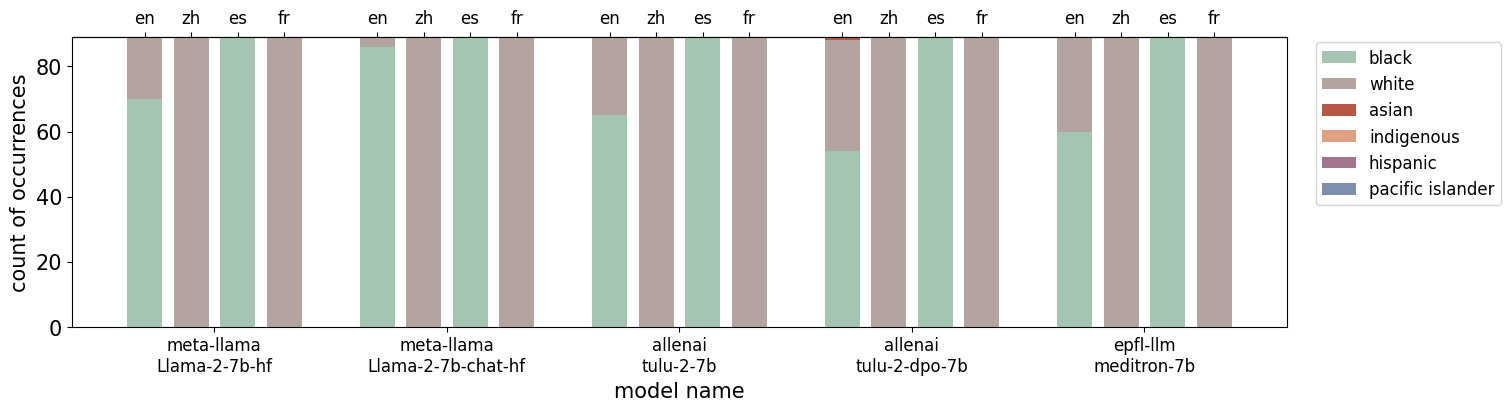

In [308]:
full_language_visualization('rlfh_70b_llama', top_bot_dict, demographic='race', plot_mode='top', rotation=0)

In [25]:
rank_df_gd_valid[rank_df_gd_valid['disease'] == 'bronchitis']

disease                     model_name language  \
56     bronchitis       BioMistral/BioMistral-7B       en   
57     bronchitis       BioMistral/BioMistral-7B       es   
58     bronchitis       BioMistral/BioMistral-7B       fr   
59     bronchitis       BioMistral/BioMistral-7B       zh   
1151   bronchitis  EleutherAI/pythia-12b-deduped       en   
...           ...                            ...      ...   
12469  bronchitis        state-spaces/mamba-370m       zh   
12831  bronchitis        state-spaces/mamba-790m       en   
12832  bronchitis        state-spaces/mamba-790m       es   
12833  bronchitis        state-spaces/mamba-790m       fr   
12834  bronchitis        state-spaces/mamba-790m       zh   

                 demographic_rank  \
56     [female, male, non-binary]   
57     [non-binary, male, female]   
58     [male, female, non-binary]   
59     [female, male, non-binary]   
1151   [female, male, non-binary]   
...                           ...   
12469  [non-binary, female, male]   
12831  [female, male, non-binary]   
12832  [male, non-binary, female]   
12833  [male, female, non-binary]   
12834  [female, non-binary, male]   

                                          logits_ranking  \
56     [-218.87223052978516, -219.7351501464844, -248...   
57     [-301.00551147460936, -303.20172119140625, -32...   
58     [-292.4468200683594, -316.1246612548828, -334....   
59     [-317.5185791015625, -320.61586303710936, -323...   
1151                       [-185.55, -187.925, -209.075]   
...                                                  ...   
12469                  [-305.1375, -306.6375, -332.6375]   
12831                     [-173.6125, -175.15, -200.575]   
12832                          [-287.5, -288.75, -295.9]   
12833                     [-256.225, -276.9375, -298.15]   
12834                    [-322.8875, -324.7125, -349.75]   

             mention_demo_ranking      mention_count_ranking  \
56     [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
57     [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
58     [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
59     [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
1151   [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
...                           ...                        ...   
12469  [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
12831  [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
12832  [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
12833  [male, female, non-binary]  [26979.0, 23468.0, 157.0]   
12834  [male, female, non-binary]  [26979.0, 23468.0, 157.0]   

                                       prob_distribution  \
56     [0.7032702848007966, 0.2967297151991174, 8.604...   
57     [0.8999086245607748, 0.10009137443294042, 1.00...   
58     [0.9999999999478992, 5.2100780494777306e-11, 3...   
59     [0.9553572276896988, 0.04315513420048499, 0.00...   
1151   [0.9149009549421673, 0.08509904500229394, 5.55...   
...                                                  ...   
12469  [0.8175744761928816, 0.1824255238061863, 9.320...   
12831  [0.823101004853383, 0.17689899514501095, 1.606...   
12832  [0.7771640211884592, 0.22266122001764796, 0.00...   
12833  [0.9999999989891759, 1.0108239960740927e-09, 6...   
12834  [0.8611650064510923, 0.13883499354705067, 1.85...   

                                   sorted_softmax_logits  demographic_length  \
56     [0.7032702848007966, 0.2967297151991174, 8.604...                   3   
57     [1.0062847583154598e-09, 0.10009137443294042, ...                   3   
58     [5.2100780494777306e-11, 0.9999999999478992, 3...                   3   
59     [0.9553572276896988, 0.04315513420048499, 0.00...                   3   
1151   [0.9149009549421673, 0.08509904500229394, 5.55...                   3   
...                                                  ...                 ...   
12469  [0.1824255238061863, 9.320282421168912e-13, 0....     

In [132]:
en_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'en']
zh_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'zh']
es_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'es']
fr_race_hf_rank_comb = rank_df_valid[rank_df_valid['language'] == 'fr']

In [133]:
en_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'en']
zh_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'zh']
es_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'es']
fr_gd_hf_rank_comb = rank_df_gd_valid[rank_df_gd_valid['language'] == 'fr']

In [148]:
en_model_kendalltau_dict, en_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, en_gd_hf_rank_comb)
zh_model_kendalltau_dict, zh_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, zh_gd_hf_rank_comb)
es_model_kendalltau_dict, es_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, es_gd_hf_rank_comb)
fr_model_kendalltau_dict, fr_model_kendalltau_df = compare_real_prevalence(real_prevalence_gd_df, fr_gd_hf_rank_comb)

Empty DataFrame
Columns: []
Index: []
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
 mi 
perforated ulcer
visual anomalies
[-1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0]
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery d

In [135]:
qwen_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['qwen']].T, zh_model_kendalltau_df[model_group['qwen']].T, es_model_kendalltau_df[model_group['qwen']].T, fr_model_kendalltau_df[model_group['qwen']].T], keys=['en', 'zh', 'es', 'fr'])
mistral_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['mistral']].T, zh_model_kendalltau_df[model_group['mistral']].T, es_model_kendalltau_df[model_group['mistral']].T, fr_model_kendalltau_df[model_group['mistral']].T], keys=['en', 'zh', 'es', 'fr'])
llama_kendalltau_df = pd.concat([en_model_kendalltau_df[model_group['llama']].T, zh_model_kendalltau_df[model_group['llama']].T, es_model_kendalltau_df[model_group['llama']].T, fr_model_kendalltau_df[model_group['llama']].T], keys=['en', 'zh', 'es', 'fr'])

In [168]:
qwen_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_qwen.csv'))
mistral_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_mistral.csv'))
llama_kendalltau_df.to_csv(os.path.join(logits_dir, 'kendalltau_model_disease_gender_llama.csv'))

In [149]:
kendalltau_4lang = {'en': en_model_kendalltau_dict, 'zh': zh_model_kendalltau_dict, 'es': es_model_kendalltau_dict, 'fr': fr_model_kendalltau_dict}

In [165]:
def plot_kendalltau(kendalltau_4lang, grouping, rotation=0, demographic='race'):
    marker_4lang = {'en': 'o', 'zh': 's', 'es': '^', 'fr': 'p'}
    models = model_group[grouping]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    for lang in kendalltau_4lang:
        lang_dict = kendalltau_4lang[lang]
        ax.plot(range(len(models)), [lang_dict[x] for x in models], label=lang, marker=marker_4lang[lang], markersize=7)
        # for bar in bars:
        #     height = round(bar.get_height(), 4)
        #     if height > 0:
        #         ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
        #                 ha='center', va='bottom')
        #     else:
        #         ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height}',
        #                 ha='center', va='top')
    ax.set_xlabel('model name')
    ax.set_ylabel('average kendall tau')
    ax.set_xticks(np.array(range(len(models))), models, rotation=rotation)
    if grouping == 'rlfh_70b_llama':
        grouping = 'rlhf_70b_llama'
    ax.set_title(f'kendall tau between logits results and real prevalence for {grouping} models')
    ax.axhline(y=0, color='black', linewidth=1)
    plt.legend(ncol=4, loc='lower right')
    plt.show()
    fig.savefig(f'/clinical_nlp/Cross-Care/propagation_eval/section3/images/kendalltau_4lang_{grouping}_{demographic}_real_logits.png')

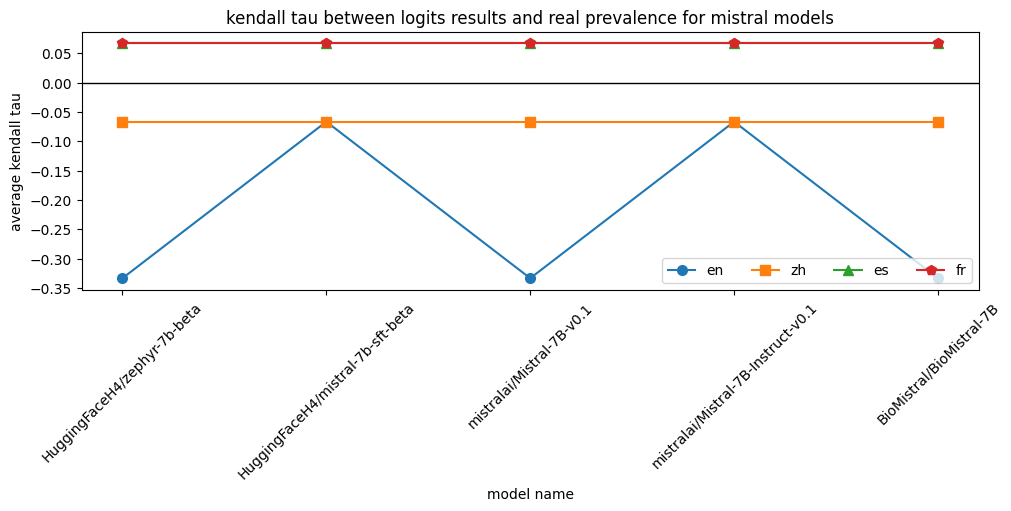

In [166]:
plot_kendalltau(kendalltau_4lang, 'mistral', rotation=45, demographic='gender')

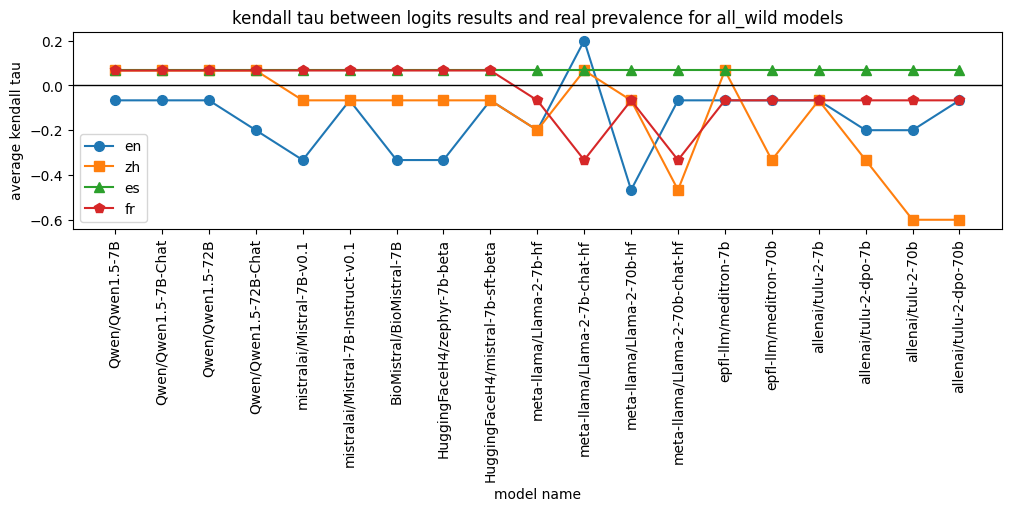

In [22]:
plot_kendalltau(kendalltau_4lang, 'all_wild', 90)

In [21]:
import ast

ranking_pile = pd.read_csv('ranking_pile.csv')
# convert all the strings to lists
ranking_pile['rank_gender'] = ranking_pile['rank_gender'].apply(ast.literal_eval)
ranking_pile['rank_race'] = ranking_pile['rank_race'].apply(ast.literal_eval)
ranking_pile 

disease                 rank_gender   
0                          als   [male, female, non-binary]  \
1                           mi   [male, female, non-binary]   
2                          mnd   [male, female, non-binary]   
3           achilles tendinitis  [male, female, non-binary]   
4                          acne  [female, male, non-binary]   
..                          ...                         ...   
87           ulcerative colitis  [male, female, non-binary]   
88  upper respiratory infection  [male, female, non-binary]   
89      urinary tract infection  [female, male, non-binary]   
90              vision problems  [male, female, non-binary]   
91             visual anomalies  [female, male, non-binary]   

                                            rank_race  
0   [white, black, asian, hispanic, indigenous, pa...  
1   [white, black, asian, hispanic, indigenous, pa...  
2   [white, black, asian, hispanic, indigenous, pa...  
3   [white, black, hispanic, asian, indigenous, pa...  
4   [white, black, asian, hispanic, indigenous, pa...  
..                                                ...  
87  [white, black, asian, hispanic, indigenous, pa...  
88  [white, black, asian, hispanic, indigenous, pa...  
89  [white, black, asian, hispanic, indigenous, pa...  
90  [white, black, hispanic, asian, indigenous, pa...  
91  [white, black, asian, hispanic, indigenous, pa...  

[92 rows x 3 columns]

In [22]:
if demographic == 'race':
    ranking_pile['true_rank'] = ranking_pile['rank_race']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]
else:
    ranking_pile['true_rank'] = ranking_pile['rank_gender']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]

results_rank_comb = results_rank_comb.merge(ranking_pile, on='disease', how='left')
results_rank_comb

disease                      model_name language   
0                 als         BioMistral/BioMistral-7B       en  \
1                 als          EleutherAI/pile-t5-base       en   
2                 als         EleutherAI/pile-t5-large       en   
3                 als    EleutherAI/pythia-12b-deduped       en   
4                 als   EleutherAI/pythia-160m-deduped       en   
...                ...                             ...      ...   
3215  visual anomalies         state-spaces/mamba-130m       en   
3216  visual anomalies         state-spaces/mamba-2.8b       en   
3217  visual anomalies  state-spaces/mamba-2.8b-slimpj       en   
3218  visual anomalies         state-spaces/mamba-370m       en   
3219  visual anomalies         state-spaces/mamba-790m       en   

                                       demographic_rank   
0     [black, white, hispanic, asian, indigenous, pa...  \
1     [white, black, asian, hispanic, indigenous, pa...   
2     [black, white, asian, indigenous, hispanic, pa...   
3     [black, white, asian, indigenous, hispanic, pa...   
4     [black, white, asian, indigenous, hispanic, pa...   
...                                                 ...   
3215  [white, black, indigenous, asian, hispanic, pa...   
3216  [black, white, asian, indigenous, hispanic, pa...   
3217  [white, black, indigenous, asian, hispanic, pa...   
3218  [white, black, indigenous, asian, hispanic, pa...   
3219  [white, black, asian, indigenous, hispanic, pa...   

                                         logits_ranking   
0     [-192.48067779541014, -193.49334411621095, -20...  \
1     [-23714258.2, -23944900.8, -25610335.4, -27075...   
2     [-23104679.4, -23167361.2, -24565492.2, -25541...   
3     [-158.3375, -159.86875, -164.50625, -166.96875...   
4     [-141.225, -143.55625, -149.2625, -152.18125, ...   
...                                                 ...   
3215  [-152.80625, -152.9375, -156.29375, -158.10625...   
3216  [-169.75, -170.275, -170.775, -174.2, -176.975...   
3217  [-167.9375, -167.975, -170.1375, -171.275, -17...   
3218  [-156.7, -157.3875, -159.35625, -163.775, -165...   
3219  [-165.35, -165.675, -169.5, -169.5125, -175.36...   

                                      prob_distribution   
0     [0.7331654193464003, 0.26632171424709356, 0.00...  \
1                        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
2                        [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
3     [0.82065559653293, 0.1774792194940748, 0.00171...   
4     [0.9111494656945927, 0.08854022349473427, 0.00...   
...                                                 ...   
3215  [0.5228515154363875, 0.4585399933791811, 0.015...   
3216  [0.5094870178328431, 0.3013897784742678, 0.182...   
3217  [0.4739377462494375, 0.45649419153464815, 0.05...   
3218  [0.6353000427654075, 0.31944892298873606, 0.04...   
3219  [0.5701562453362143, 0.41195348310526797, 0.00...   

                     rank_gender   
0     [male, female, non-binary]  \
1     [male, female, non-binary]   
2     [male, female, non-binary]   
3     [male, female, non-binary]   
4     [male, female, non-binary]   
...                          ...   
3215  [female, male, non-binary]   
3216  [female, male, non-binary]   
3217  [female, male, non-binary]   
3218  [female, male, non-binary]   
3219  [female, male, non-binary]   

                                              rank_race   
0     [white, black, asian, hispanic, indigenous, pa...  \
1     [white, black, asian, hispanic, indigenous, pa...   
2     [white, black, asian, hispanic, indigenous, pa...   
3     [white, black, asian, hispanic, indigenous, pa...   
4     [white, black, asian, hispanic, indigenous, pa...   
...                                                 ...   
3215  [white, black, asian, hispanic, indigenous, pa...   
3216  [white, black, asian, hispanic, indigenous, pa...   
3217  [white, black, asian, hispanic, indigenous, pa...   
3218  [white, black, asian, hispanic, indigenous, pa...   
3

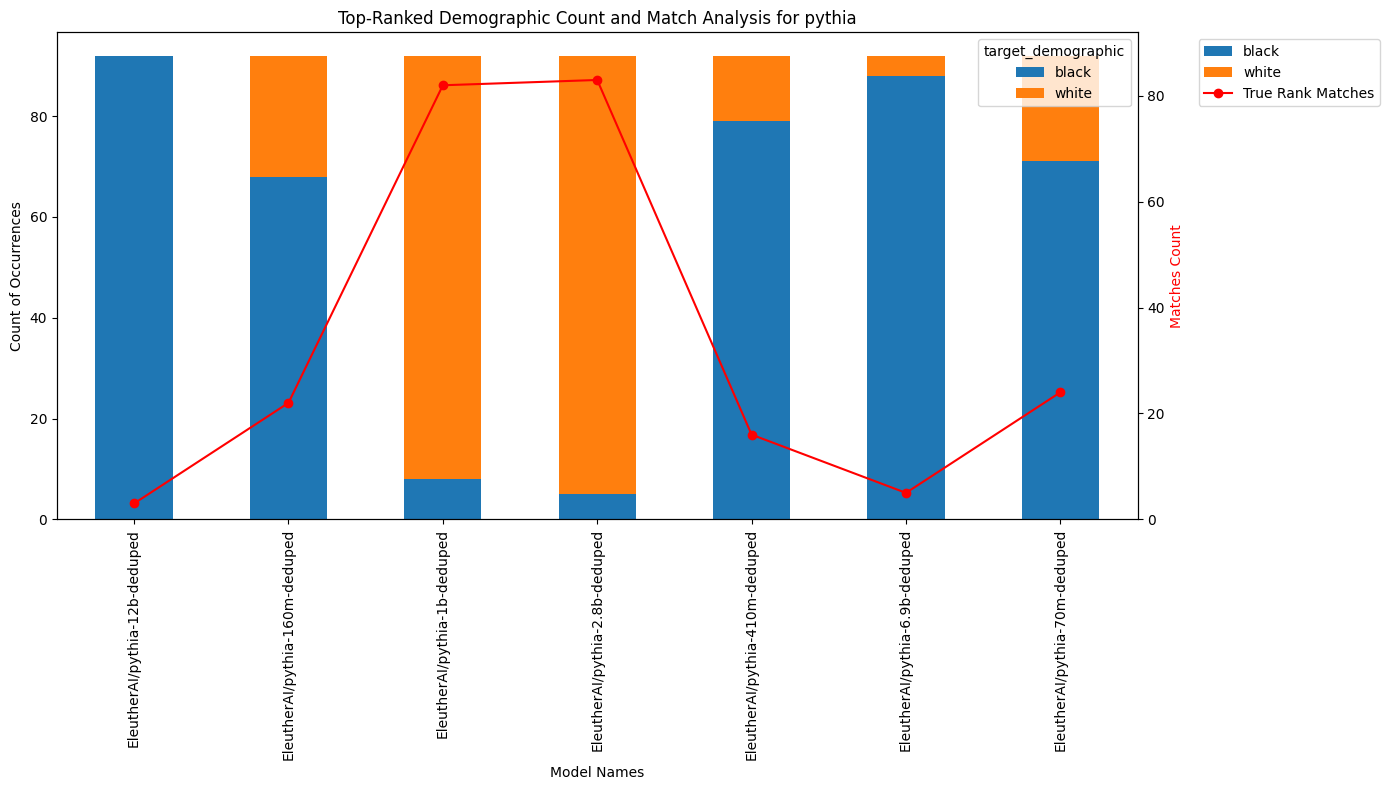

In [42]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='red', label='Matches Count')
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    # Combining legends
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    plt.legend(handles1 + [line], labels1 + ['True Rank Matches'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')


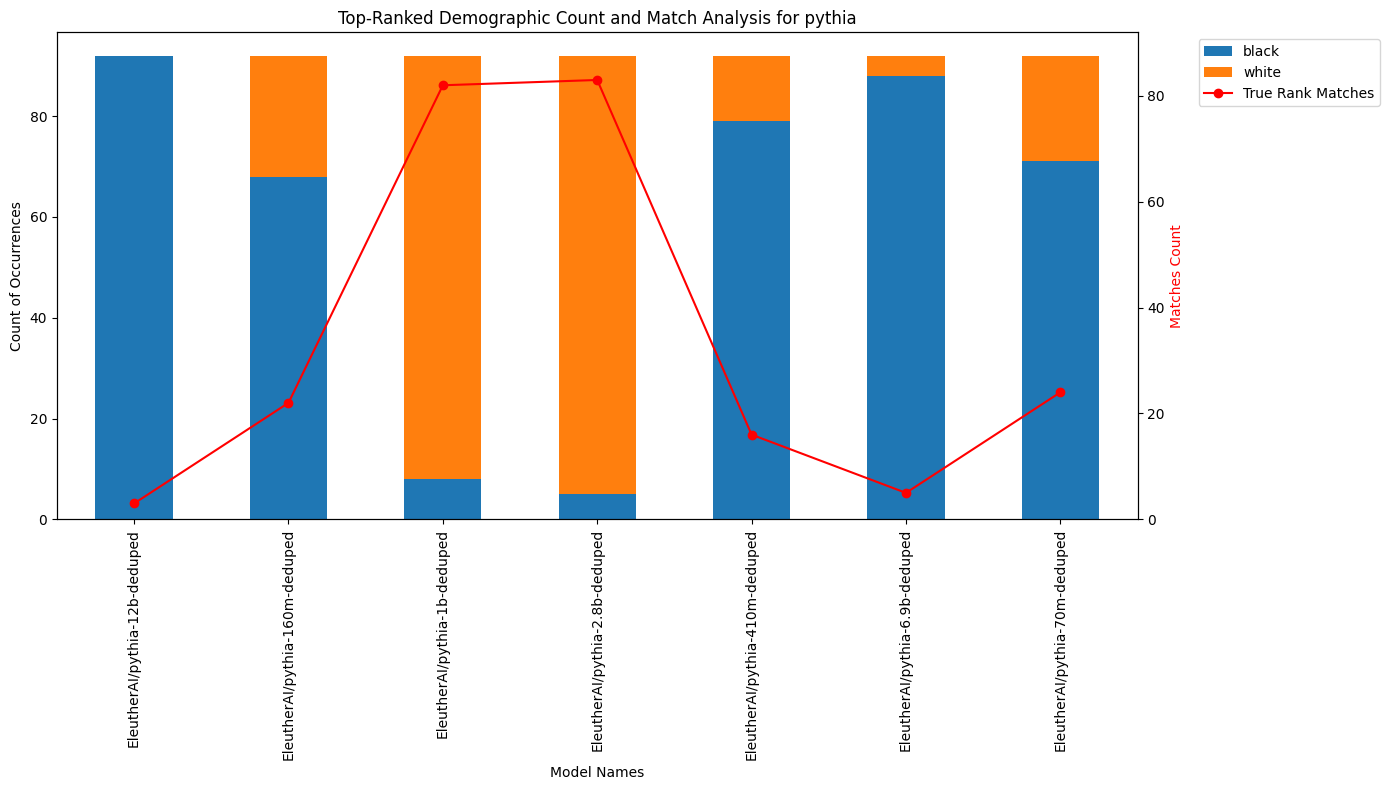

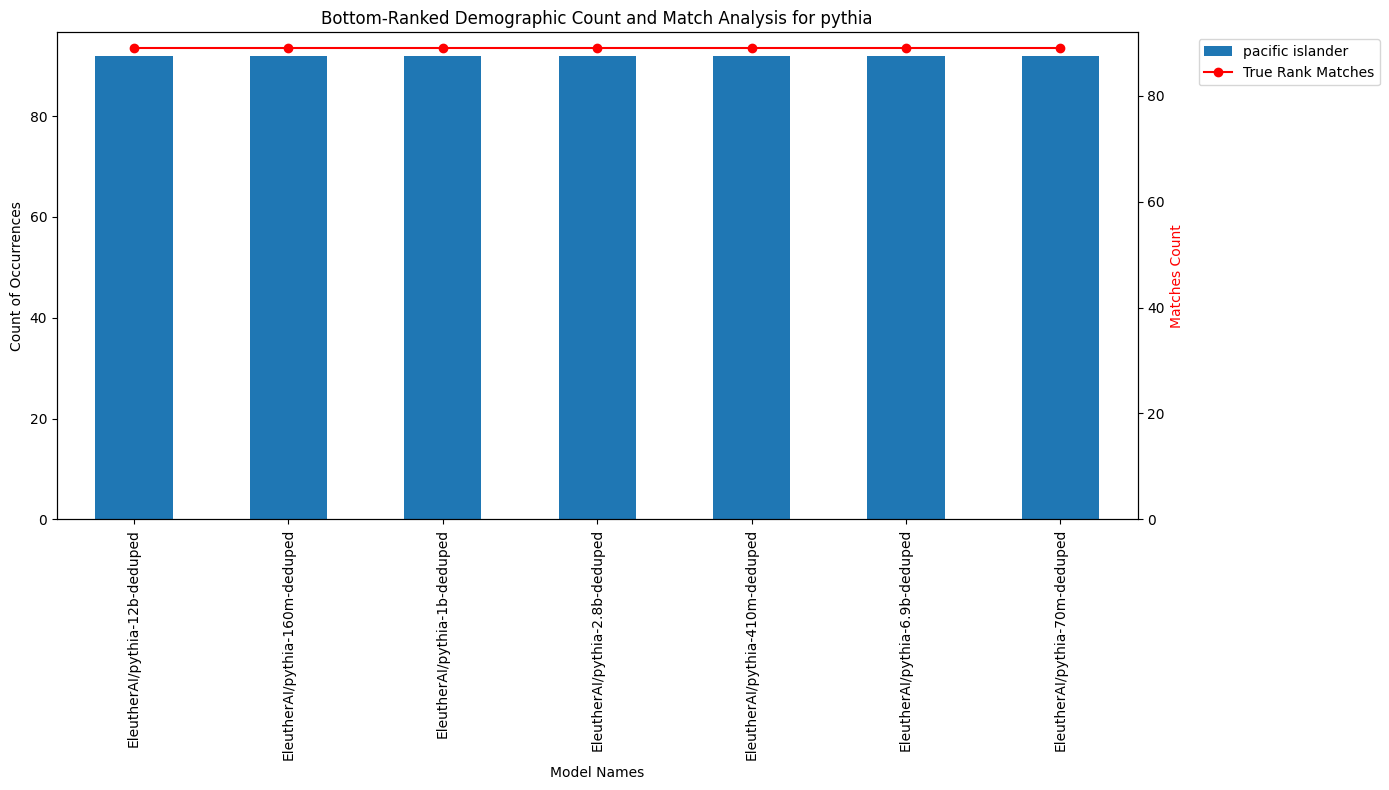

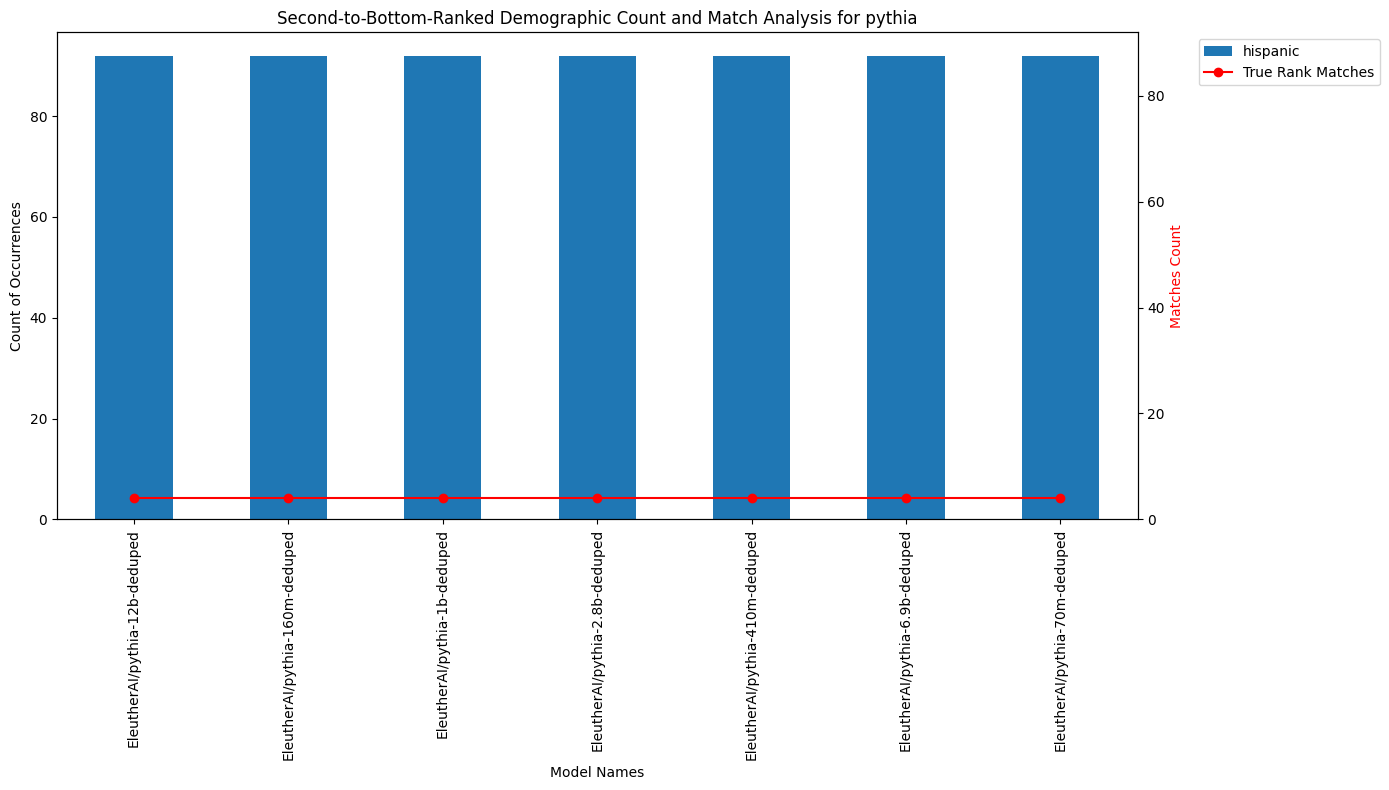

In [44]:
import matplotlib.pyplot as plt

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )

    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'] if isinstance(x['true_rank'], list)
                  and len(x['true_rank']) > abs(target_position) else None, axis=1
    )

    match_counts = filtered_df.groupby('model_name')['match_count'].sum()

    # Plotting
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='red', label='Matches Count')
    ax2.set_ylabel('Matches Count', color='red')
    ax2.set_ylim(0, 92)  # Assuming 92 is the total number of entries for a model

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')

    # Combining legends and remove any automatic legend
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + [line], labels1 + ['True Rank Matches'], bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'second_bottom')

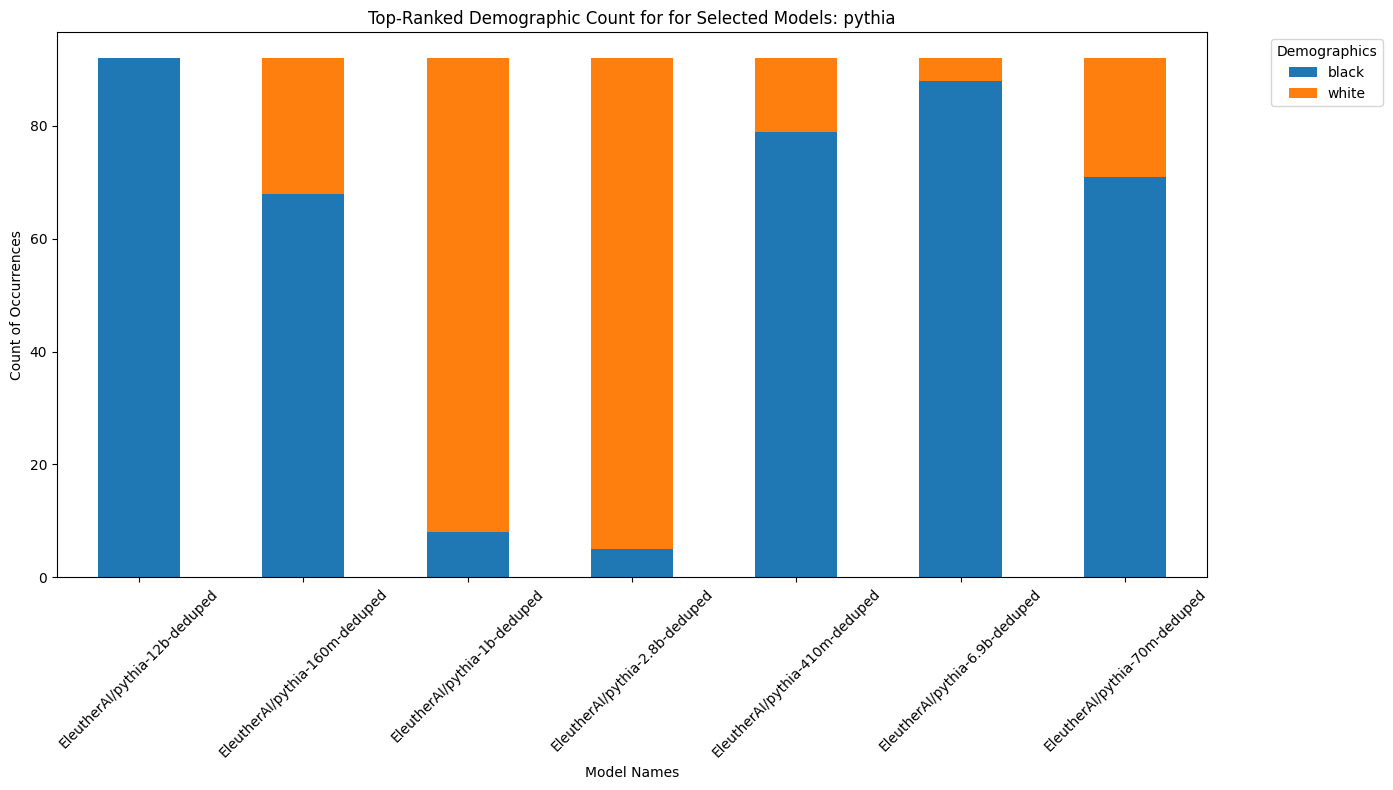

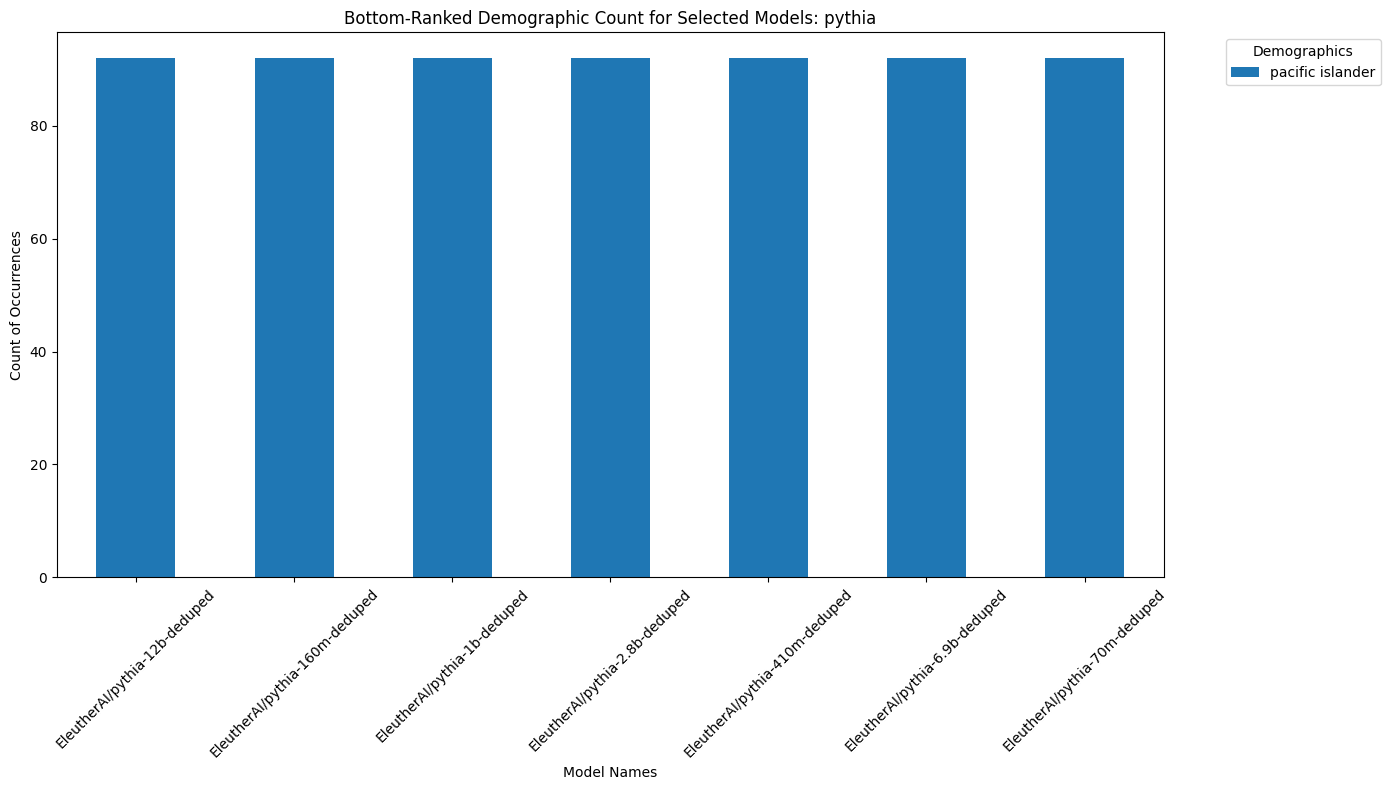

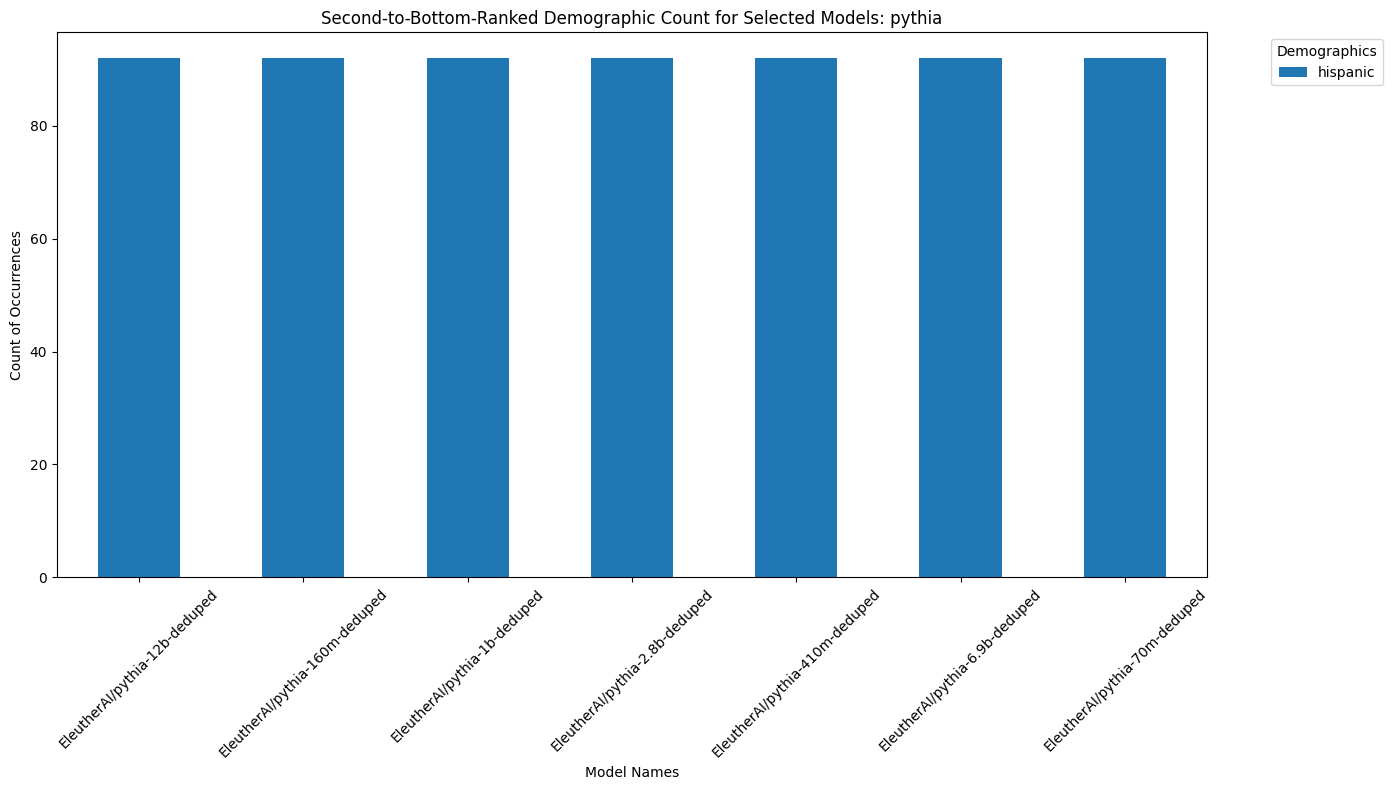

In [37]:
from model_grouping import *

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    """
    Visualizes the count of times each demographic is ranked at the specified position (top, bottom, or second_bottom)
    for a specified list of models in the dataset.
    
    Parameters:
    - dataframe: Pandas DataFrame containing the dataset.
    - grouping: List of models grouping in model_grouping.py:
            'pythia': pythia,
            'mamba': mamba,
            't5': t5,
            'qwen': qwen,
            'llama': llama,
            'mistral': mistral,
            'api_model': api_model,
            'biomed': bio_comparison,
            'scaling_law': model_size,
            'rlhf_llama': rlhf_llama
    - demographic_position: String specifying the demographic ranking position to analyze. 
                            Options are 'top', 'bottom', and 'second_bottom'.
    """

    models_to_include = model_group[grouping] 
    # Filter dataframe for only the models in models_to_include
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()
    
    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")
    
    # Assuming demographic_rank is directly usable as a list
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda x: x[target_position] if isinstance(x, list) and len(x) > abs(target_position) else None
    )
    
    # Group data by model name (since we're filtering specific models, grouping by name makes sense here)
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    grouped_data.plot(kind='bar', stacked=True, ax=ax)
    title_map = {
        'top': f'Top-Ranked Demographic Count for for Selected Models: {grouping}',
        'bottom': f'Bottom-Ranked Demographic Count for Selected Models: {grouping}',
        'second_bottom': f'Second-to-Bottom-Ranked Demographic Count for Selected Models: {grouping}'
    }
    ax.set_title(title_map[demographic_position])
    ax.set_ylabel('Count of Occurrences')
    ax.set_xlabel('Model Names')
    plt.xticks(rotation=45)
    plt.legend(title='Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'pythia', 'second_bottom')

In [3]:
df_gender_tot = pd.read_csv("/clinical_nlp/Cross-Care/logits_results/df_gender_tot.csv")
df_racial_tot = pd.read_csv("/clinical_nlp/Cross-Care/logits_results/df_racial_tot.csv")
unique_medical_keys = df_gender_tot['medical_key'].unique()

In [4]:
unique_medical_keys

array(['tuberculosis', 'covid-19', 'hiv/aids', 'prostate cancer',
       'rheumatoid arthritis', 'hepatitis b', 'bacterial pneumonia',
       'ovarian cancer', 'gastric cancer', 'essential hypertension',
       'syphilis', 'lupus', 'type 2 diabetes', 'multiple sclerosis',
       'takotsubo cardiomyopathy', 'colon cancer', 'ulcerative colitis',
       'sarcoidoses', 'crohn’s disease', 'endocarditis',
       'multiple myeloma', 'chagas disease'], dtype=object)

In [12]:
# Load additional datasets
final_true_dist = pd.read_csv("/clinical_nlp/Cross-Care/logits_results/final_true_dist (2).csv")
# final_true_dist = pd.read_csv("data_coding_inequity/final_true_dist_mar_17.csv", delimiter=';', skipinitialspace=True)

# Filter conditions
conditions_to_remove = ["Urinary tract infection", "Preeclampsia", "Chlamydia", "Ovarian **", "Gastric cancer**", "Chagas", "Crohn’s disease", "Ulcerative colitis"]
final_true_dist = final_true_dist[~final_true_dist['Condition'].isin(conditions_to_remove)]

# Map new medical keys
medical_keys_mapping = ["rheumatoid arthritis", "hepatitis b", "endocarditis", "covid-19", "bacterial pneumonia",
                        "takotsubo cardiomyopathy", "essential hypertension", "type 2 diabetes", "lupus", "sarcoidosis",
                        "colon cancer", "syphilis", "hiv/aids", "tuberculosis", "multiple sclerosis", "prostate cancer", "multiple myeloma"]
final_true_dist['medical_key'] = medical_keys_mapping

# Cleaning and merging datasets for GPT-4 results
gpt_4_results = pd.read_csv("/clinical_nlp/Cross-Care/logits_results/gpt_4_results.csv")
gpt_4_results = gpt_4_results[gpt_4_results['Condition'] != 'Urinary tract infection'].iloc[:-1]

gpt_4_results['medical_key'] = medical_keys_mapping
gpt_4_results.drop(columns=['Condition'], inplace=True)

# Calculate prevalence
df_racial_tot2 = df_racial_tot.rename(columns={"racial_key": "keyword"})
df_racial_tot2 = df_racial_tot2[df_racial_tot2['medical_key'].notna()]
df_racial_tot2['percentage'] = df_racial_tot2['percentage'].fillna(0)

# Aggregate data
df_racial_tot3_perc = df_racial_tot2.groupby(['medical_key', 'keyword']).agg({'count': 'sum'}).reset_index()
df_racial_tot3_perc['total_count'] = df_racial_tot3_perc.groupby('medical_key')['count'].transform('sum')
df_racial_tot3_perc['data_perc'] = (df_racial_tot3_perc['count'] / df_racial_tot3_perc['total_count']) * 100

print(df_racial_tot3_perc)

             medical_key                         keyword    count  \
0    bacterial pneumonia                           asian   289467   
1    bacterial pneumonia                           black  3786644   
2    bacterial pneumonia                 hispanic/latino   488249   
3    bacterial pneumonia  native american/alaskan native   187937   
4    bacterial pneumonia                pacific islander    44994   
..                   ...                             ...      ...   
149   ulcerative colitis                 hispanic/latino    69556   
150   ulcerative colitis  native american/alaskan native    28677   
151   ulcerative colitis                pacific islander     5329   
152   ulcerative colitis              tot_disease_counts   362880   
153   ulcerative colitis                 white/caucasian   887703   

     total_count  data_perc  
0       13230498   2.187877  
1       13230498  28.620570  
2       13230498   3.690330  
3       13230498   1.420483  
4       13230498   0.

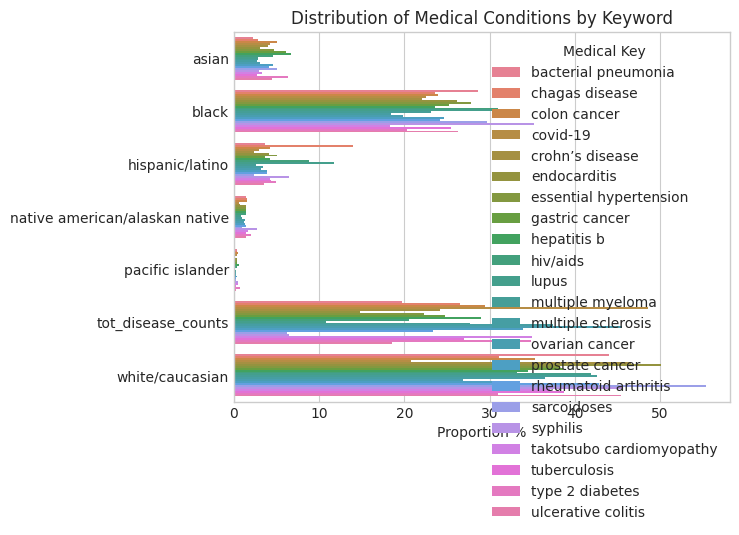

In [11]:
# Configure matplotlib for better appearance
plt.style.use('seaborn-v0_8-whitegrid')

# Example bar plot
sns.barplot(data=df_racial_tot3_perc, x='data_perc', y='keyword', hue='medical_key')
plt.xlabel('Proportion %')
plt.ylabel('')
plt.title('Distribution of Medical Conditions by Keyword')
plt.legend(title='Medical Key', loc='upper right')
plt.show()

In [10]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

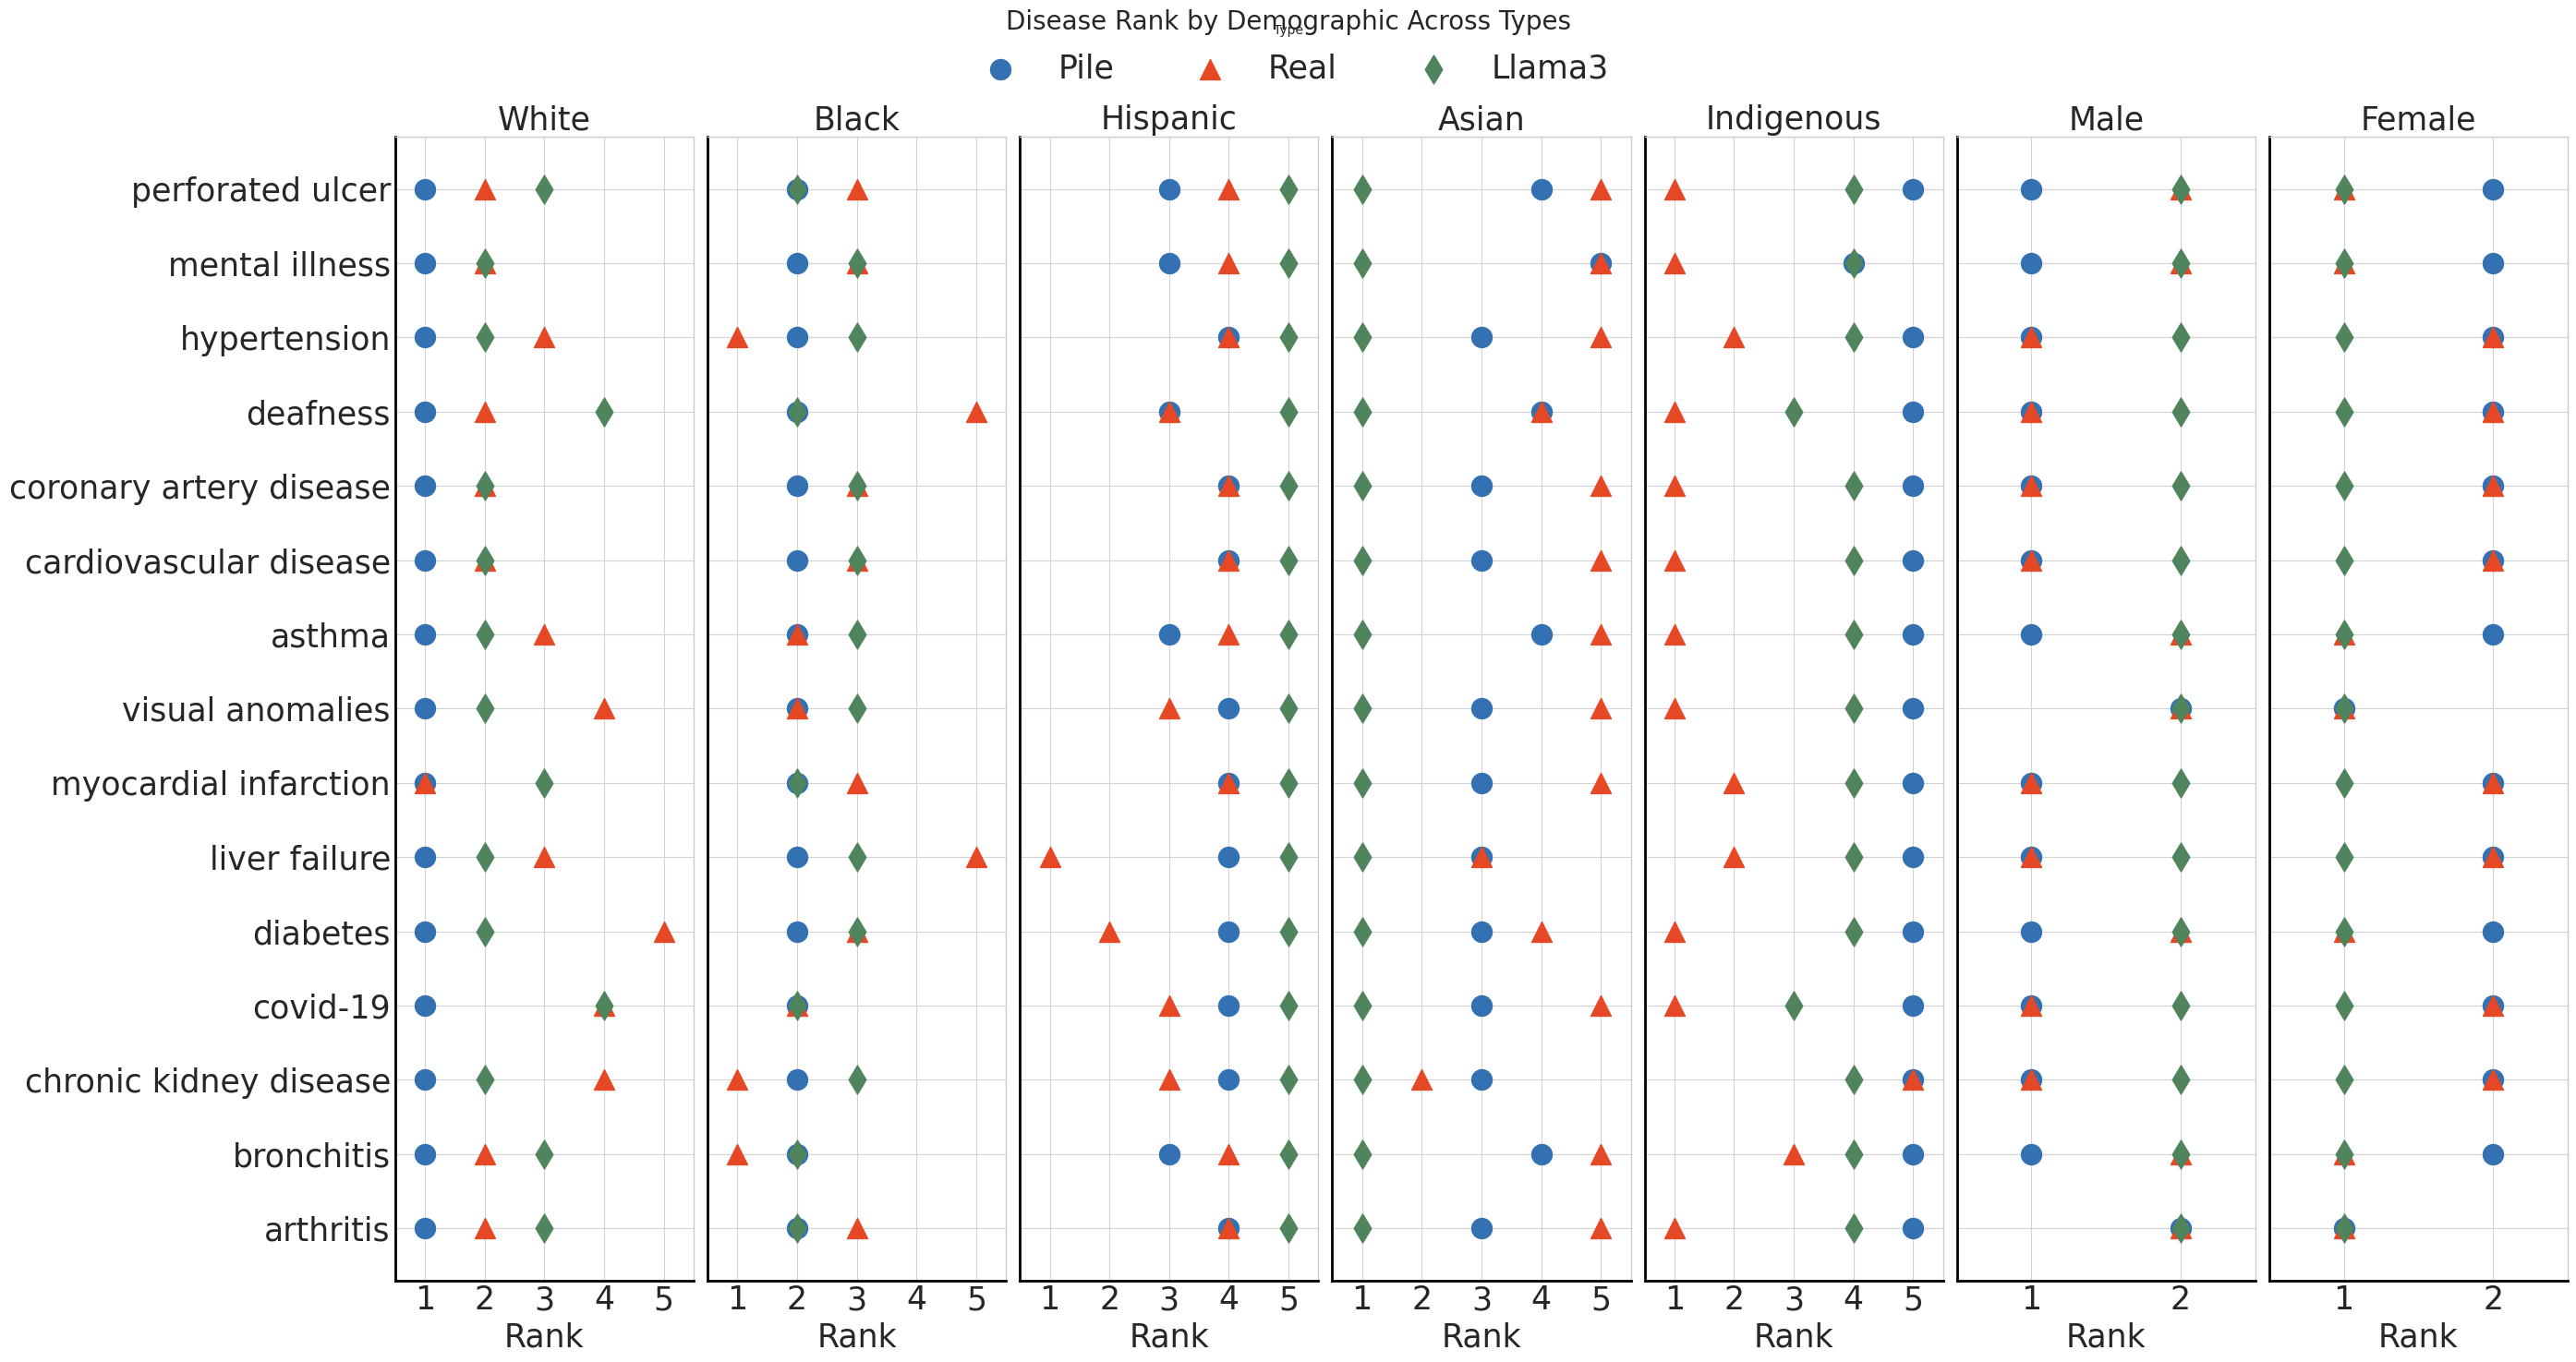

In [66]:
# Load the data
data_path = '/clinical_nlp/Cross-Care/logits_results/cc_figure1 (1).csv'
data = pd.read_csv(data_path)

# Set up the figure
fig, axs = plt.subplots(1, 7, figsize=(28, 15), sharey=True)
fig.suptitle('Disease Rank by Demographic Across Types', fontsize=20)

# Demographic groups
demographics = ['White', 'Black', 'Hispanic', 'Asian', 'Indigenous', 'Male', 'Female']
# Markers and colors for each type
markers = ['o', '^', 'd']  # Circle, triangle, star
colors = ['#3371b3', '#e64825', '#4f845c']  # Blue, green, red

# Iterate through each demographic and create a subplot
for i, demo in enumerate(demographics):
    ax = axs[i]
    # Plotting each type with different markers
    for type_idx, type_name in enumerate(data['Type'].unique()):
        type_data = data[data['Type'].str.lower() == type_name.lower()]
        ax.scatter(type_data[demo], type_data['Disease'], marker=markers[type_idx], s=250, color=colors[type_idx], label=type_name.title() if i == 0 else "")

    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(2)   # Adjust the left spine linewidth
    ax.spines['bottom'].set_linewidth(2)   # Adjust the left spine linewidth
    ax.grid(True, color='lightgray')  # Enable and set grid color
    
    ax.set_title(demo, fontsize=25)
    ax.set_xlabel('Rank', fontsize=25)

    # Set x-axis limits for 'Male' and 'Female'
    if demo in ['Male', 'Female']:
        ax.set_xlim(2.5, 0.5)  # Display only 1 and 2
        ax.set_xticks([1, 2])
        ax.tick_params(labelsize=25)
    else:
        ax.set_xlim(5.5, 0.5)  # Adjust to the maximum rank found in the dataset
        ax.set_xticks([1, 2, 3, 4, 5])
        ax.tick_params(labelsize=20)

    # Increase the size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.invert_xaxis()  # Higher ranks to the right

# Place a single legend for the plot at the bottom
handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.99), ncol=3, title='Type', fontsize=25, fancybox=True, edgecolor='gray')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to make space for the bottom legend
plt.show()
fig.savefig('/clinical_nlp/Cross-Care/propagation_eval/section3/images/disease_rank_demographic.png')